This is work of Alina Dzemiantsevich ademencevich@gmail.com

## Project description
You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans is more profitable in order to adjust the advertising budget.


You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze clients' behavior and determine which prepaid plan is more profitable.

### Description of the plans

Remember! Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabyes.

**Surf**

- Monthly charge: 20$
- 500 monthly minutes, 50 texts, and 15 GB of data <br>
After exceeding the package limits:<br>
- 1 minute: 3 cents
- 1 text message: 3 cents
- 1 GB of data: 10 dollars

**Ultimate**

- Monthly charge: 70$
- 3000 monthly minutes, 1000 text messages, and 30 GB of data <br>
After exceeding the package limits:<br>
- 1 minute: 1 cent
- 1 text message: 1 cent
- 1 GB of data: 7 dollars

### Step 1. Open the data file and study the general information


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from math import floor, ceil
from functools import reduce

# The calls table (data on calls):
# id — unique call identifier
# call_date — call date
# duration — call duration (in minutes)
# user_id — the identifier of the user making the call

#megaline_calls = pd.read_csv('/datasets/megaline_calls.csv')
megaline_calls = pd.read_csv('megaline_calls.csv')

In [2]:
megaline_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [3]:
megaline_calls.head(5)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [4]:
#let's get descriptive statistics for only one numeric column of the table - duration
megaline_calls['duration'].describe()

count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64

In [5]:
# The internet table (data on web sessions):
# id — unique session identifier
# mb_used — the volume of data spent during the session (in megabytes)
# session_date — web session date
# user_id — user identifier

#megaline_internet = pd.read_csv('/datasets/megaline_internet.csv')
megaline_internet = pd.read_csv('megaline_internet.csv')

In [6]:
megaline_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [7]:
megaline_internet.head(5)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [8]:
#let's get descriptive statistics for mb_used column
megaline_internet['mb_used'].describe()

count    104825.000000
mean        366.713701
std         277.170542
min           0.000000
25%         136.080000
50%         343.980000
75%         554.610000
max        1693.470000
Name: mb_used, dtype: float64

In [9]:
# The messages table (data on texts):
# id — unique text message identifier
# message_date — text message date
# user_id — the identifier of the user sending the text

#megaline_messages = pd.read_csv('/datasets/megaline_messages.csv')
megaline_messages = pd.read_csv('megaline_messages.csv')

In [10]:
megaline_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [11]:
megaline_messages.head(5)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [12]:
# The plans table (data on the plans):
# plan_name — calling plan name
# usd_monthly_fee — monthly charge in US dollars
# minutes_included — monthly minute allowance
# messages_included — monthly text allowance
# mb_per_month_included — data volume allowance (in megabytes)
# usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
# usd_per_message — price per text after exceeding the package limits
# usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

#megaline_plans = pd.read_csv('/datasets/megaline_plans.csv')
megaline_plans = pd.read_csv('megaline_plans.csv')
megaline_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [13]:
#The users table (data on users):

# user_id — unique user identifier
# first_name — user's name
# last_name — user's last name
# age — user's age (years)
# reg_date — subscription date (dd, mm, yy)
# churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this data was retrieved)
# city — user's city of residence
# plan — calling plan name

#megaline_users = pd.read_csv('/datasets/megaline_users.csv')
megaline_users = pd.read_csv('megaline_users.csv')

In [14]:
megaline_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [15]:
megaline_users.head(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


### Conclusion

We have five tables containing data:
- about users of Megaline telecom operator
- about plans which Megaline offers to the clients
- about internet usage by the users
- about usage of messages 
- about calls

We see that four tables of five do not contain missing values. Only one column in table 'megaline_users' contain NaNs. This is 'churn_date' column. It has 34 non-null objects when other columns contain 500 non-null objects. So we can conclude that only 34 users of 500 cancelled the Megaline services.

### Step 2. Prepare the data

**Convert the data to the necessary types**

We see in info method for megaline_calls table that we have 'call_date' column with date of the call. It has object type. We neeed to convert it into datetype.

In [16]:
megaline_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [17]:
megaline_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [18]:
#Let's convert 'call_date' column into datetime 
megaline_calls['call_date'] = pd.to_datetime(megaline_calls['call_date'],format='%Y.%m.%d')
megaline_calls.sample()

,id,user_id,call_date,duration
117567,1411_170,1411,2018-10-28,3.69


In [19]:
#Now we see that 'call_date' column is datetime64[ns] type
megaline_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


Let's look once again on megaline_internet table:

In [20]:
megaline_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [21]:
megaline_internet.sample()

,id,user_id,session_date,mb_used
80065,1374_141,1374,2018-08-05,467.72


We see that we have 'session_date' column with type object. It have to be converted into datetime type.

In [22]:
#Let's convert 'session_date' column into datetime 
megaline_internet['session_date'] = pd.to_datetime(megaline_internet['session_date'],format='%Y.%m.%d')
megaline_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


So now 'session_date' column has datetime64[ns] type. 

Let's consider 'megaline_messages' table.

In [23]:
megaline_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [24]:
megaline_messages.sample()

,id,user_id,message_date
38615,1254_102,1254,2018-10-22


We have here 'message_date' column which is also should be datetime type. Let's convert it.

In [25]:
megaline_messages['message_date'] = pd.to_datetime(megaline_messages['message_date'],format='%Y.%m.%d')
megaline_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


We also have users table with two columns with dates - 'reg_date' and 'churn_date'. 

First one 'reg_date' contain dates of subscription, 
second one 'churn_date' contain the dates when the user stopped using the service.

In [26]:
megaline_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [27]:
#all dates presented in format %Y.%m.%d
megaline_users[megaline_users['churn_date'].notnull()].sample()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
441,1441,Piedad,Myers,23,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-03-08,ultimate,2018-08-19


In [28]:
#Let's convert columns 'reg_date' and 'churn_date'
megaline_users['reg_date'] = pd.to_datetime(megaline_users['reg_date'],format='%Y.%m.%d')
megaline_users['churn_date'] = pd.to_datetime(megaline_users['churn_date'],format='%Y.%m.%d')
megaline_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


So we have all dates as datetime types.

We don't need to convert any column in megaline_plans table.

**Find and eliminate errors in the data**

Explain what errors you found and how you removed them. Note: many calls have a duration of 0.0 minutes. These might be missed calls. Whether or not to preprocess these values is up to you; assess how much their absence would affect the results of your analysis.

We have five tables
- megaline_users
- megaline_calls
- megaline_internet
- megaline_messages
- megaline_plans

We already saw that only one column in users table contain missing values - churn_date. And we know that if the value in this column is missing, the calling plan was being used when this data was retrieved.

We also saw that megaline_plans table contain only two rows - one rows for one plan. And we don't have missing values of errors in this table.

Let's check all other tables for some other errors in data.

In [29]:
#I won't check the megaline_users table for NaNs and errors because we have seen we don't have it there.
megaline_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [30]:
#we have only unique user id values in a table
len(megaline_users['user_id'].unique())

500

In [31]:
#We see that we have only 458 unique first names. But it's ok, many people have the same first name
len(megaline_users['first_name'].unique())

458

In [32]:
#We see that we have names that occur multiple times 
megaline_users['first_name'].value_counts()

Leonila     3
Jasper      3
Seymour     3
Lucius      2
Errol       2
           ..
Olin        1
Hai         1
Shay        1
Rebbecca    1
Shena       1
Name: first_name, Length: 458, dtype: int64

In [33]:
#The same situation with the last name
len(megaline_users['last_name'].unique())

399

In [34]:
megaline_users['last_name'].value_counts()

David        3
Morrison     3
Grimes       3
Kelley       3
Velazquez    3
            ..
Cain         1
Robinson     1
Adkins       1
Bean         1
Dickson      1
Name: last_name, Length: 399, dtype: int64

In [35]:
#Fortunately we don't have users with 0 age.
megaline_users['age'].min()

18

In [36]:
#We see that our 500 users live in 73 cities
len(megaline_users['city'].unique())

73

In [37]:
#Biggest number of users live in New York-Newark-Jersey City
megaline_users['city'].value_counts()

New York-Newark-Jersey City, NY-NJ-PA MSA          80
Los Angeles-Long Beach-Anaheim, CA MSA             29
Dallas-Fort Worth-Arlington, TX MSA                21
Chicago-Naperville-Elgin, IL-IN-WI MSA             19
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA    17
                                                   ..
Raleigh-Cary, NC MSA                                1
El Paso, TX MSA                                     1
Greensboro-High Point, NC MSA                       1
Stockton, CA MSA                                    1
Cape Coral-Fort Myers, FL MSA                       1
Name: city, Length: 73, dtype: int64

In [38]:
#we have data for 2018 year only
print(megaline_users['reg_date'].min())
print(megaline_users['reg_date'].max())
print()
print(megaline_users['churn_date'].min())
print(megaline_users['churn_date'].max())

2018-01-01 00:00:00
2018-12-31 00:00:00

2018-07-31 00:00:00
2018-12-31 00:00:00


In [39]:
#We see tat we don't have duplicate rows in a table
megaline_users.duplicated().sum()

0

I didn't find any errors of data in megaline_users table.

Let's consider megaline_calls table

In [40]:
megaline_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [41]:
#Looks like we have only unique data among 'id' column
len(megaline_calls['id'].unique())

137735

In [42]:
#We have data about calls only of 481 user. But in table user we had 500 users id. 
#So looks like not all users used calls.

len(megaline_calls['user_id'].unique())

481

In [43]:
#We see here that we also have data for 2018 year only
print(megaline_calls['call_date'].min())
print(megaline_calls['call_date'].max())

2018-01-15 00:00:00
2018-12-31 00:00:00


In [44]:
#Longest call was 37 minutes long
megaline_calls['duration'].max()

37.6

In [45]:
#We have calls lasted 0 minutes
megaline_calls['duration'].min()

0.0

In [46]:
#Let's find out haw many of them we have
megaline_calls[megaline_calls['duration']==0].count()

id           26834
user_id      26834
call_date    26834
duration     26834
dtype: int64

In [47]:
#So we have 26834 calls with 0 duration (in minutes). This is 19,48% of data.
megaline_calls[megaline_calls['duration']==0].sample(5)

,id,user_id,call_date,duration
130329,1468_81,1468,2018-10-10,0.0
115345,1404_139,1404,2018-12-23,0.0
73305,1261_52,1261,2018-05-09,0.0
89191,1324_1262,1324,2018-07-20,0.0
99666,1357_601,1357,2018-09-10,0.0


In [48]:
megaline_calls['duration'].describe()

count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64

In [49]:
megaline_calls[megaline_calls['duration']>0]['duration'].describe()

count    110901.000000
mean          8.378196
std           5.354567
min           0.010000
25%           4.150000
50%           7.710000
75%          11.820000
max          37.600000
Name: duration, dtype: float64

I would not delete these values or not to fill it somehow because it's valuable data which tell us that almost 20% of calls are not successful.

If compare descriptive statistics for dataset with calls of zero duration with part of the dataset without such calls we see that median value differs on two minutes, average duraion differs on three minutes, quartiles differs a lot. 

So let's leave this column as it is for further analysis. 

In [50]:
#We don't have duplicates in a table megaline_calls
megaline_calls.duplicated().sum()

0

We processed megaline_calls table, let's consider now megaline_internet table.

In [51]:
megaline_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [52]:
#Looks like we have only unique data among 'id' column. It's good
len(megaline_internet['id'].unique())

104825

In [53]:
#Here we can see that only 489 users used megaline internet among 500 users we have.
# at least more number of users used internet than made calls

len(megaline_internet['user_id'].unique())

489

In [54]:
#Here we can also see that we have data for 2018 year only
print(megaline_internet['session_date'].min())
print(megaline_internet['session_date'].max())

2018-01-15 00:00:00
2018-12-31 00:00:00


In [55]:
print('mb used min',megaline_internet['mb_used'].min()) 
print('mb used max',megaline_internet['mb_used'].max()) 

mb used min 0.0
mb used max 1693.47


In [56]:
megaline_internet.head(5)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [57]:
#We don't have duplicates in a table megaline_internet
megaline_internet.duplicated().sum()

0

I don't see the errors in data of megaline_internet table. Let's consider megaline_messages table.

In [58]:
megaline_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [59]:
# We have only unique data among 'id' column.
len(megaline_messages['id'].unique())

76051

In [60]:
#Only 402 users of 500 used messages
len(megaline_messages['user_id'].unique())

402

In [61]:
#Here we can also see that we have data for 2018 year only
print(megaline_messages['message_date'].min())
print(megaline_messages['message_date'].max())

2018-01-15 00:00:00
2018-12-31 00:00:00


In [62]:
#We don't have duplicates in a table megaline_messages
megaline_messages.duplicated().sum()

0

We don't have mistakes to eliminate in the tables. 

We have calls with zero duration (19,48%). But it's ok, it is normal.

And we have column 'churn_date' in the megaline_users table with NaNs. About this columns we know that if the value in this column is missing, the calling plan was being used when this data was retrieved.

So we have all data in order and we can proceed with the next task. 

**For each user, find:**
- The number of calls made and minutes used per month
- The number of text messages sent per month
- The volume of data per month
- The monthly profit from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan)

Let's find **the number of calls each user made and minutes used per month**

In [63]:
megaline_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


Because we should find number of calls each user made and minutes **per month** not per year (we have data for 2018 year), let's add to the table 'megaline_calls' column 'month' to be able to count what we are looking for.

In [64]:
megaline_calls['month'] = pd.DatetimeIndex(megaline_calls['call_date']).month

In [65]:
#now we have months
megaline_calls.sample(5)

,id,user_id,call_date,duration,month
121009,1424_27,1424,2018-12-26,7.44,12
121327,1426_115,1426,2018-12-26,14.65,12
1791,1009_213,1009,2018-12-08,6.27,12
70646,1251_657,1251,2018-05-01,19.32,5
119822,1417_501,1417,2018-08-07,0.07,8


We know that each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. So let's round all the calls before building the pivot table.

In [66]:
#apply the function
megaline_calls['calls_rounded'] = megaline_calls['duration'].apply(ceil)
megaline_calls

,id,user_id,call_date,duration,month,calls_rounded
0,1000_93,1000,2018-12-27,8.52,12,9
1,1000_145,1000,2018-12-27,13.66,12,14
2,1000_247,1000,2018-12-27,14.48,12,15
3,1000_309,1000,2018-12-28,5.76,12,6
4,1000_380,1000,2018-12-30,4.22,12,5
...,...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72,11,9
137731,1499_200,1499,2018-10-20,10.89,10,11
137732,1499_201,1499,2018-09-21,8.12,9,9
137733,1499_202,1499,2018-10-10,0.37,10,1


In [67]:
#Everything works as should
megaline_calls[megaline_calls['duration'] ==0.01].head()

,id,user_id,call_date,duration,month,calls_rounded
1697,1009_119,1009,2018-11-27,0.01,11,1
3354,1011_207,1011,2018-11-26,0.01,11,1
7806,1036_398,1036,2018-10-11,0.01,10,1
12532,1054_259,1054,2018-12-14,0.01,12,1
15975,1062_215,1062,2018-05-16,0.01,5,1


In [68]:
#So we can make pivot table to find number of calls and minutes for each of 481 users from megaline_calls table
calls_per_month = megaline_calls.pivot_table(index =['user_id','month'],values='calls_rounded',aggfunc=['count','sum'])

#replace name of columns of pivot table to more comfortable usage
calls_per_month.columns =['Num_calls','Total_minutes']
calls_per_month


Num_calls  Total_minutes
user_id month                          
1000    12            16            124
1001    8             27            182
        9             49            315
        10            65            393
        11            64            426
...                  ...            ...
1498    12            39            339
1499    9             41            346
        10            53            385
        11            45            308
        12            65            496

[2258 rows x 2 columns]

If take a look on the pivot table we see that some users used services (here is calls) only in one month:user 1000 used calls only in 12th month, other - user 1498 used calls in 9,10 and 12 month. So we can make a conclusion that users used calls quite irregularly.

In [69]:
#reset the multi index of pivot table to ordinary index for more comfortable usage
calls_per_month.reset_index(inplace=True)
calls_per_month.head()

,user_id,month,Num_calls,Total_minutes
0,1000,12,16,124
1,1001,8,27,182
2,1001,9,49,315
3,1001,10,65,393
4,1001,11,64,426


So we counted the number of calls and total duration of calls for each of 481 user who used the calls.

Let's find **the number of text messages sent per month** for each user

In [70]:
megaline_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


I also add here a new column of 'month_msg' name with month when message was sent.

In [71]:
megaline_messages['month'] = pd.DatetimeIndex(megaline_messages['message_date']).month
megaline_messages.sample(5)

,id,user_id,message_date,month
29276,1179_72,1179,2018-08-10,8
25028,1147_234,1147,2018-10-09,10
20642,1130_317,1130,2018-12-28,12
44978,1302_83,1302,2018-11-06,11
55522,1349_130,1349,2018-12-28,12


In [72]:
#build a pivot table to count the number of messages sent each month by each user
msg_per_month = megaline_messages.pivot_table(index =['user_id','month'],values='id',aggfunc='count')
msg_per_month

id
user_id month    
1000    12     11
1001    8      30
        9      44
        10     53
        11     36
...            ..
1496    9      21
        10     18
        11     13
        12     11
1497    12     50

[1806 rows x 1 columns]

We see here the same situation of irregular usage of messages.

In [73]:
#reset the multi index of pivot table to ordinary index for more comfortable usage
msg_per_month.reset_index(inplace=True)

#replace name of 'id' column of pivot table to 'Total_msg'
msg_per_month.rename({'id':'Total_msg'}, axis='columns',inplace=True)

msg_per_month.head()

,user_id,month,Total_msg
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


So I counted the number of messages sent by each user for each month of 2018.

Let's find **the volume of data per month** for each user

In [74]:
megaline_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


I will add a new column of 'month_internet' name which will contain month when user used internet traffic.

In [75]:
megaline_internet['month'] = pd.DatetimeIndex(megaline_internet['session_date']).month
megaline_internet.sample(5)

,id,user_id,session_date,mb_used,month
78442,1366_131,1366,2018-10-21,318.32,10
92080,1427_85,1427,2018-06-06,551.89,6
94408,1440_46,1440,2018-09-28,303.02,9
56240,1254_193,1254,2018-11-14,0.00,11
63868,1293_204,1293,2018-10-13,545.61,10


In [76]:
#build a pivot table to count the volume of data per month for each user
mb_per_month = megaline_internet.pivot_table(index =['user_id','month'],values='mb_used',aggfunc='sum')
mb_per_month

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30
...                 ...
1498    12     23137.69
1499    9      12984.76
        10     19492.43
        11     16813.83
        12     22059.21

[2277 rows x 1 columns]

In [77]:
#reset the multi index of pivot table to ordinary index for more comfortable usage
mb_per_month.reset_index(inplace=True)
mb_per_month.head()

,user_id,month,mb_used
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30


I counted the total number of Megabytes each user spent on a internet per each month.

Let's find **the monthly profit from each user** 

(subtract the free package limit from the total number of calls, text messages, and data;multiply the result by the calling plan value; add the monthly charge depending on the calling plan)

In [78]:
#Let's merge three tables calls_per_month, msg_per_month and mb_per_month
data_frames = [calls_per_month, msg_per_month, mb_per_month]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'month'],
                                            how='outer'), data_frames)

In [79]:
df_merged.fillna(0,inplace=True)
df_merged

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used
0,1000,12,16.0,124.0,11.0,1901.47
1,1001,8,27.0,182.0,30.0,6919.15
2,1001,9,49.0,315.0,44.0,13314.82
3,1001,10,65.0,393.0,53.0,22330.49
4,1001,11,64.0,426.0,36.0,18504.30
...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13039.91
2289,1361,5,0.0,0.0,2.0,1519.69
2290,1482,10,0.0,0.0,2.0,0.00
2291,1108,12,0.0,0.0,0.0,233.17


In [80]:
#Looks like everything is correct
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        2293 non-null   int64  
 1   month          2293 non-null   int64  
 2   Num_calls      2293 non-null   float64
 3   Total_minutes  2293 non-null   float64
 4   Total_msg      2293 non-null   float64
 5   mb_used        2293 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 125.4 KB


Now we can use df_merged table to count **the monthly profit from each user**.

Let's remember, after building the pivot tables we had:

- 2258 rows with the number of calls and minutes for each user ('calls_num' table)
- 1806 rows with the number of messages sent each month by each user ('msg_per_month' table)
- 2277 rows with the volume of data per month for each user ('mb_per_month' table)

I united all these data by unique used_id and by month to which data correspond. 

To count the profit, I should:
- subtract the free package limit from the total number of calls, text messages, and data;
- multiply the result by the calling plan value; 
- add the monthly charge depending on the calling plan

In [81]:
#to count the profit let's add the plan for each user of df_merged table
#to do that let's create a data slice with data user-plan from megaline_users dataset
users_plans = megaline_users[['user_id','plan']]
#users_plans

#let's join df_merged table and users_plans table
df_merged = pd.merge(df_merged, users_plans, how='outer', on='user_id')
#df_merged.info()

In [82]:
#So now we have plan for each user and can count the profit
df_merged.sample(5)

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan
582,1126,7.0,124.0,951.0,94.0,25768.85,ultimate
324,1069,12.0,102.0,714.0,98.0,14820.66,ultimate
2093,1460,12.0,63.0,389.0,50.0,30836.81,ultimate
860,1183,12.0,96.0,596.0,97.0,20848.36,surf
1329,1292,7.0,17.0,111.0,0.0,21099.24,surf


In [83]:
#I will fill all NaN in following columns 'Num_calls', 'Total_minutes', 'Total_msg' and 'mb_used'
#Because it is obvious that if we have NaNs user did not used those services

df_merged['Num_calls'].fillna(0,inplace=True)
df_merged['Total_minutes'].fillna(0,inplace=True)
df_merged['Total_msg'].fillna(0,inplace=True)
df_merged['mb_used'].fillna(0,inplace=True)
df_merged['month'].fillna(0,inplace=True)

In [84]:
# So we can check that now we don't have NaNs in 'Num_calls', 'Total_minutes', 'Total_msg' and 'mb_used' columns
# we have zeroes instead 

#df_merged[df_merged['Num_calls'].isnull()]
#df_merged[df_merged['Total_minutes'].isnull()]
#df_merged[df_merged['Total_msg'].isnull()]
df_merged[df_merged['mb_used'].isnull()]

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan


In [85]:
#We see that each user in users table has plan
#we don't have nan in 'plan' column
df_merged[df_merged['plan'].isnull()]

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan


In [86]:
#Let's remembers what exactly plans we have

# The plans table (data on the plans):
# plan_name — calling plan name
# usd_monthly_fee — monthly charge in US dollars
# minutes_included — monthly minute allowance
# messages_included — monthly text allowance
# mb_per_month_included — data volume allowance (in megabytes)
# usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
# usd_per_message — price per text after exceeding the package limits
# usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

megaline_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [87]:
#to count the profit, first we should know how many services each user used above the limit of his plan
#write the function to count over usage of minutes of calls
def over_usage_calls(row):
    plan = row['plan']
    calls = row['Total_minutes']
    
    if plan == 'surf':
        if calls < 500:
            over_calls = 0
        else:
            over_calls = calls - 500
    #if plan is ultimate
    else:
        if calls < 3000:
            over_calls = 0
        else:
            over_calls = calls - 3000
    return over_calls

#the function to count over usage of messages
def over_usage_msg(row):
    plan = row['plan']
    msg = row['Total_msg']
    
    if plan == 'surf':
        if msg < 50:
            over_msg = 0
        else:
            over_msg = msg - 50
    #if plan is ultimate
    else:
        if msg < 1000:
            over_msg = 0
        else:
            over_msg = msg - 1000
    return over_msg


#let's write the function to count over usage of megabytes
def over_usage_mb(row): 
    plan = row['plan']
    mb =row['mb_used']
    
    if plan == 'surf':
        if  mb < 15360:
            over_mb = 0
        else: 
            over_mb = mb - 15360
    #if plan is ultimate
    else:
        if  mb < 30720:
            over_mb = 0
        else: 
            over_mb = mb - 30720
    return over_mb

In [88]:
#apply the functions
df_merged['over_calls'] = df_merged.apply(over_usage_calls,axis=1)
df_merged['over_msg'] = df_merged.apply(over_usage_msg,axis=1)
df_merged['over_mb'] = df_merged.apply(over_usage_mb,axis=1)

In [89]:
#check if everything counted correct for plan surf
df_merged[(df_merged['Total_minutes']>500) & (df_merged['plan']=='surf')].sample()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb
1649,1362,4.0,95.0,643.0,42.0,12415.19,surf,143.0,0.0,0.0


In [90]:
#check if everything counted correct for plan ultimate
#we don't have such clients of ultimate plan with over usage of minutes
df_merged[(df_merged['Total_minutes']>3000) & (df_merged['plan']=='ultimate')]

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb


In [91]:
#check if everything counted correct
#but some clients of ultimate plan have over usage of megabytes
df_merged[(df_merged['plan']=='ultimate')& (df_merged['over_mb']>0)].head(5)

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb
20,1006,12.0,9.0,59.0,139.0,32118.82,ultimate,0.0,0.0,1398.82
94,1028,3.0,6.0,39.0,66.0,36061.04,ultimate,0.0,0.0,5341.04
95,1028,4.0,7.0,53.0,77.0,37761.59,ultimate,0.0,0.0,7041.59
96,1028,5.0,8.0,67.0,84.0,32907.83,ultimate,0.0,0.0,2187.83
97,1028,6.0,11.0,49.0,66.0,37907.14,ultimate,0.0,0.0,7187.14


In [92]:
#write a function to convert used megabytes into gigabytes

#I won't use this function, just left it 

#let's follow the logic: 
#For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. 
#If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

def mb_to_gb(mb):
    
    #if megabytes used per month divisible by 1024 witout remainder of that division
    #we assign exact the same number of GB used
    if (mb % 1024) == 0:
        gb = int(mb/1024)
    #in other case if we have for example 1025 megabytes used we add 1 GB to the number of GB used
    #for that I will use ceil function
    else:
        gb = int(ceil(mb/1024))
    return gb

In [93]:
df_merged['over_GB'] = df_merged['over_mb'] / 1024
df_merged['over_GB'] = df_merged['over_GB'].apply(ceil)
df_merged.head()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB
0,1000,12.0,16.0,124.0,11.0,1901.47,ultimate,0.0,0.0,0.00,0
1,1001,8.0,27.0,182.0,30.0,6919.15,surf,0.0,0.0,0.00,0
2,1001,9.0,49.0,315.0,44.0,13314.82,surf,0.0,0.0,0.00,0
3,1001,10.0,65.0,393.0,53.0,22330.49,surf,0.0,3.0,6970.49,7
4,1001,11.0,64.0,426.0,36.0,18504.30,surf,0.0,0.0,3144.30,4


In [94]:
df_merged[df_merged['over_mb']>0].head(10)

#looking on the 11th row for example we see that function works well:
#5312.82 / 1024 = 5,18 rounded as 6 GB upwards

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB
3,1001,10.0,65.0,393.0,53.0,22330.49,surf,0.0,3.0,6970.49,7
4,1001,11.0,64.0,426.0,36.0,18504.30,surf,0.0,0.0,3144.30,4
5,1001,12.0,56.0,412.0,44.0,19369.18,surf,0.0,0.0,4009.18,4
7,1002,11.0,55.0,386.0,32.0,19345.08,surf,0.0,0.0,3985.08,4
9,1003,12.0,149.0,1104.0,50.0,27044.14,surf,604.0,0.0,11684.14,12
11,1004,6.0,44.0,275.0,18.0,20672.82,surf,0.0,0.0,5312.82,6
12,1004,7.0,49.0,381.0,26.0,24516.62,surf,0.0,0.0,9156.62,9
13,1004,8.0,49.0,354.0,25.0,27981.74,surf,0.0,0.0,12621.74,13
14,1004,9.0,42.0,301.0,21.0,18852.72,surf,0.0,0.0,3492.72,4
16,1004,11.0,54.0,476.0,25.0,21850.78,surf,0.0,0.0,6490.78,7


Let's finish counting the profit. Let's write a function which will :
- add the monthly charge depending on the calling plan
- to the product of over usage of calls, minutes and internet and tariff plan value;

In [95]:
#Let's remember the plan values
megaline_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [96]:
#Let's write now the function to calculate sum for over usage of calls, messages and internet

def profit(row):
    #by using row accessor we will take each row of each user separately
    # so we're creating variables of plan, over_calls, over_msg and over_GB inside the function
    # and we can operate them for each user
    plan = row['plan']
    over_calls = row['over_calls']
    over_msg = row['over_msg']
    over_GB = row['over_GB']
    
    if plan == 'surf':
        profit = 20 + over_calls*0.03 + over_msg*0.03 + over_GB*10
    
    else:
        profit = 70 + over_calls*0.01 + over_msg*0.01 + over_GB*7
    
    return profit    

In [97]:
#apply the function and coint the profit
df_merged['profit'] = df_merged.apply(profit,axis=1)

#looks like everything works right
df_merged.head()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB,profit
0,1000,12.0,16.0,124.0,11.0,1901.47,ultimate,0.0,0.0,0.00,0,70.00
1,1001,8.0,27.0,182.0,30.0,6919.15,surf,0.0,0.0,0.00,0,20.00
2,1001,9.0,49.0,315.0,44.0,13314.82,surf,0.0,0.0,0.00,0,20.00
3,1001,10.0,65.0,393.0,53.0,22330.49,surf,0.0,3.0,6970.49,7,90.09
4,1001,11.0,64.0,426.0,36.0,18504.30,surf,0.0,0.0,3144.30,4,60.00


In [98]:
#Let's check some entries where month was NaN replaced to null (because some users did not used the services)
df_merged[df_merged['month']==0.0]

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB,profit
2293,1025,0.0,0.0,0.0,0.0,0.0,ultimate,0.0,0.0,0.0,0,70.0
2294,1129,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0
2295,1143,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0
2296,1269,0.0,0.0,0.0,0.0,0.0,ultimate,0.0,0.0,0.0,0,70.0
2297,1275,0.0,0.0,0.0,0.0,0.0,ultimate,0.0,0.0,0.0,0,70.0
2298,1307,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0
2299,1319,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0
2300,1378,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0
2301,1463,0.0,0.0,0.0,0.0,0.0,ultimate,0.0,0.0,0.0,0,70.0
2302,1473,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0


In [99]:
#Let's find if the user did not used the services because he stopped the usage of a plan
users_date = megaline_users[['user_id','reg_date','churn_date']]

#add columns 'reg_date','churn_date' into df_merged table
df_merged = pd.merge(df_merged,users_date,how='left', on='user_id')

#let's check what we got
df_merged[df_merged['month']==0.0]

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB,profit,reg_date,churn_date
2293,1025,0.0,0.0,0.0,0.0,0.0,ultimate,0.0,0.0,0.0,0,70.0,2018-10-28,NaT
2294,1129,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0,2018-11-10,2018-12-27
2295,1143,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0,2018-10-26,NaT
2296,1269,0.0,0.0,0.0,0.0,0.0,ultimate,0.0,0.0,0.0,0,70.0,2018-09-13,2018-12-15
2297,1275,0.0,0.0,0.0,0.0,0.0,ultimate,0.0,0.0,0.0,0,70.0,2018-11-29,NaT
2298,1307,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0,2018-12-31,NaT
2299,1319,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0,2018-06-17,NaT
2300,1378,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0,2018-12-17,NaT
2301,1463,0.0,0.0,0.0,0.0,0.0,ultimate,0.0,0.0,0.0,0,70.0,2018-11-27,NaT
2302,1473,0.0,0.0,0.0,0.0,0.0,surf,0.0,0.0,0.0,0,20.0,2018-12-31,NaT


We see that only two users actually stopped the usage of service. 

I would drop this data, it's only 10 users so it would not affect the analysis results. I think it would affects statistics a little but it's not critical. 

We don't have a full picture of how these users used the services. It's more complex to figure out the way to fill data about months of their usage (or non usage) then just to drop these rows.

In [100]:
#Delete 10 rows from df_merged table
df_merged.drop(df_merged[df_merged['month']==0.0].index, inplace=True)
#I will also drop columns 'reg_date','churn_date'
df_merged.drop(columns=['reg_date','churn_date'],inplace=True)

df_merged[df_merged['month']==0.0]

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB,profit


In [101]:
#So now we have 2293 rows of full data
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        2293 non-null   int64  
 1   month          2293 non-null   float64
 2   Num_calls      2293 non-null   float64
 3   Total_minutes  2293 non-null   float64
 4   Total_msg      2293 non-null   float64
 5   mb_used        2293 non-null   float64
 6   plan           2293 non-null   object 
 7   over_calls     2293 non-null   float64
 8   over_msg       2293 non-null   float64
 9   over_mb        2293 non-null   float64
 10  over_GB        2293 non-null   int64  
 11  profit         2293 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 232.9+ KB


I calculated the profit for each user for each month according to his plan and usage or over usage of his plan.

### Conclusion

I converted all necessary column into required data types. For all it was to convert object type into date type. I did it for 'call_date', 'session_date','message_date', reg_date' and 'churn_date' columns. All this columns contain date data, so now we have all dates as datetime types.

I explored all the tables for errors. 
I didn't find so obvious mistakes in the data. Except of calls - we have a lot of calls with zero duration in minutes. It is about 19,48% of data. But I think it is normal to have such data. Not always you call someone sucessfully, it's an usual situation.

I compared descriptive statistics for dataset with calls of zero duration with part of the dataset without such calls. I found that median value differs for such two data slices - median value differs on two minutes, average duraion differs on three minutes, quartiles differs quite a lot.
So I left this column as it is for further analysis.

Among five tables I found only one column contain missing values - churn_date in users table. And we know that if the value in this column is missing, the calling plan was being used when this data was retrieved. So everything is under control.

I didn't found any duplicates in the tables.

All dates and obviously all the data we have for 2018 year only.

I added the 'month' column to each table and calculated:
- number of calls for each user per month 
- number of minutes of callsfor each user per month 
- the number of messages for each user per month 
- the volume of data for each user per month 

After calculating those data I merged the pivot tables into one by iser_id and month columns.
After that I calculated the monthly profit each user brought to the Megaline company.

### Step 3. Analyze the data

Describe the customers' behavior. Find the minutes, texts, and volume of data the users of each plan require per month. Calculate the mean, dispersion, and standard deviation. Plot histograms. Describe the distributions.

In [102]:
#Let's create data slices with users of surf plan and users of ultimate plan separately
# to look on it more closely

#data slice with users of surf plan only
surf_users = df_merged.query('plan == "surf"')
surf_users

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB,profit
1,1001,8.0,27.0,182.0,30.0,6919.15,surf,0.0,0.0,0.00,0,20.00
2,1001,9.0,49.0,315.0,44.0,13314.82,surf,0.0,0.0,0.00,0,20.00
3,1001,10.0,65.0,393.0,53.0,22330.49,surf,0.0,3.0,6970.49,7,90.09
4,1001,11.0,64.0,426.0,36.0,18504.30,surf,0.0,0.0,3144.30,4,60.00
5,1001,12.0,56.0,412.0,44.0,19369.18,surf,0.0,0.0,4009.18,4,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2285,1194,11.0,0.0,0.0,62.0,42866.10,surf,0.0,12.0,27506.10,27,290.36
2286,1194,12.0,0.0,0.0,56.0,31088.49,surf,0.0,6.0,15728.49,16,180.18
2289,1349,10.0,0.0,0.0,76.0,13093.55,surf,0.0,26.0,0.00,0,20.78
2290,1349,11.0,0.0,0.0,72.0,17128.26,surf,0.0,22.0,1768.26,2,40.66


In [103]:
surf_users.describe()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit
count,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000
mean,1242.755245,9.182454,59.811825,428.749523,31.159568,16558.283490,61.458996,7.012715,3647.354336,3.865226,60.706408
std,139.227939,2.468199,32.017989,234.453150,33.566717,8013.513327,125.524813,19.470891,5419.664587,5.445627,55.388042
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,1120.000000,8.000000,39.000000,272.000000,3.000000,11986.520000,0.000000,0.000000,0.000000,0.000000,20.000000
50%,1245.000000,10.000000,60.000000,425.000000,24.000000,16829.310000,0.000000,0.000000,1469.310000,2.000000,40.360000
75%,1358.000000,11.000000,79.000000,576.000000,47.000000,20999.610000,76.000000,0.000000,5639.610000,6.000000,80.360000
max,1499.000000,12.000000,205.000000,1510.000000,266.000000,70931.590000,1010.000000,216.000000,55571.590000,55.000000,590.370000


In [104]:
#number of surf users who did not used the calls
print('Number of surf users who did not used the calls',len(surf_users[surf_users['Total_minutes']==0]))

#percentage of surf users who did not used the calls
print('Percentage of surf users who did not used the calls {:.2f}%'.format((len(surf_users[surf_users['Total_minutes']==0]) / len(surf_users['Total_minutes']))*100))


Number of surf users who did not used the calls 29
Percentage of surf users who did not used the calls 1.84%


In [105]:
#number of surf users who did not used the messages
print('Number of surf users who did not used the messages',len(surf_users[surf_users['Total_msg']==0]))

#percentage of surf users who did not used the messages
print('Percentage of surf users who did not used the messages {:.2f}%'.format((len(surf_users[surf_users['Total_msg']==0]) / len(surf_users['Total_msg']))*100))


Number of surf users who did not used the messages 351
Percentage of surf users who did not used the messages 22.31%


In [106]:
#number of surf users who did not used the megabytes
print('Number of surf users who did not used the megabytes',len(surf_users[surf_users['mb_used']==0]))

#percentage of surf users who did not used the megabytes
print('Percentage of surf users who did not used the megabytes {:.2f}%'.format((len(surf_users[surf_users['mb_used']==0]) / len(surf_users['mb_used']))*100))


Number of surf users who did not used the megabytes 15
Percentage of surf users who did not used the megabytes 0.95%


In [107]:
#number of surf users who went out of minutes limits
print('Number of surf users who went out of minutes limits',len(surf_users[surf_users['over_calls']>0]))

#percentage of surf users who went out of minutes limits
print('Percentage of surf users who went out of minutes limits {:.2f}%'.format((len(surf_users[surf_users['over_calls']>0]) / len(surf_users['over_calls']))*100))

Number of surf users who went out of minutes limits 566
Percentage of surf users who went out of minutes limits 35.98%


In [108]:
#number of surf users who went out of messages limits
print('Number of surf users who went out of messages limits',len(surf_users[surf_users['over_msg']>0]))

#percentage of surf users who went out of messages limits
print('Percentage of surf users who went out of messages limits {:.2f}%'.format((len(surf_users[surf_users['over_msg']>0]) / len(surf_users['over_msg']))*100))

Number of surf users who went out of messages limits 340
Percentage of surf users who went out of messages limits 21.61%


In [109]:
#number of surf users who went out of megabytes limits
print('Number of surf users who went out of megabytes limits',len(surf_users[surf_users['over_mb']>0]))

#percentage of surf users who went out of megabytes limits
print('Percentage of surf users who went out of megabytes limits {:.2f}%'.format((len(surf_users[surf_users['over_mb']>0]) / len(surf_users['over_mb']))*100))


Number of surf users who went out of megabytes limits 911
Percentage of surf users who went out of megabytes limits 57.91%


**Let's look on behavior of Surf plan users:**

- Users of Surf plan require in average 59 calls per month (mean value of Num_calls column)
- If count in minutes: users require in average 487 minutes for calls each month (mean value of Total_minutes column)
- If assuming that 59 calls will last 428 minutes, each call last about 7,25 minutes.
- Users of Surf plan require 31 messages in average per month (mean value of Total_msg column)
- Users of Surf plan require 16558 megabytes in average per month (mean value of mb_used column)

**How many minutes, messages, megabytes users lack:**
- Users of Surf plan lack inside tariff plan 61 minutes of calls (or if assume that one call last 7,25 minutes  - Users lack about 8 calls)
- Users of Surf plan lack inside tariff plan in average 7 messages per month
- Users of Surf plan lack inside tariff plan in average 3.86 GB per month

**Percentage of Surf users who went out of limits:**
- Percentage of Surf users who went out of minutes limits 35.98%
- Percentage of Surf users who went out of messages limits 21.61%
- Percentage of Surf users who went out of megabytes limits 57.91%

**Percentage of Surf users who did not used the services:**
- Percentage of Surf users who did not used the calls 1.84%
- Percentage of Surf users who did not used the messages 22.31%
- Percentage of Surf users who did not used the megabytes 0.95%

In [110]:
# data slice with users of ultimate plan
ultimate_users = df_merged.query('plan == "ultimate"')
ultimate_users

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB,profit
0,1000,12.0,16.0,124.0,11.0,1901.47,ultimate,0.0,0.0,0.00,0,70.0
19,1006,11.0,2.0,10.0,15.0,2068.37,ultimate,0.0,0.0,0.00,0,70.0
20,1006,12.0,9.0,59.0,139.0,32118.82,ultimate,0.0,0.0,1398.82,2,84.0
26,1008,10.0,71.0,476.0,21.0,17106.99,ultimate,0.0,0.0,0.00,0,70.0
27,1008,11.0,63.0,446.0,37.0,23676.72,ultimate,0.0,0.0,0.00,0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2231,1493,12.0,65.0,473.0,0.0,15289.09,ultimate,0.0,0.0,0.00,0,70.0
2247,1497,12.0,54.0,300.0,50.0,11106.55,ultimate,0.0,0.0,0.00,0,70.0
2287,1204,11.0,0.0,0.0,42.0,21346.95,ultimate,0.0,0.0,0.00,0,70.0
2288,1204,12.0,0.0,0.0,78.0,36730.05,ultimate,0.0,0.0,6010.05,6,112.0


In [111]:
ultimate_users.describe()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.0,720.0,720.000000,720.000000,720.000000
mean,1253.330556,9.151389,60.626389,430.450000,37.551389,17214.699694,0.0,0.0,309.552222,0.330556,72.313889
std,150.915644,2.558495,33.242994,240.508762,34.767179,7851.897435,0.0,0.0,1575.328576,1.627873,11.395108
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,70.000000
25%,1126.000000,8.000000,36.000000,260.000000,7.000000,12666.955000,0.0,0.0,0.000000,0.000000,70.000000
50%,1241.500000,10.000000,61.000000,424.000000,30.000000,16858.340000,0.0,0.0,0.000000,0.000000,70.000000
75%,1401.000000,11.000000,80.000000,565.250000,61.000000,21014.527500,0.0,0.0,0.000000,0.000000,70.000000
max,1497.000000,12.000000,191.000000,1369.000000,166.000000,46595.330000,0.0,0.0,15875.330000,16.000000,182.000000


In [112]:
#number of ultimate users who did not used the calls
print('Number of ultimate users who did not used the calls',len(ultimate_users[ultimate_users['Total_minutes']==0]))

#percentage of ultimate users who did not used the calls
print('Percentage of ultimate users who did not used the calls {:.2f}%'.format((len(ultimate_users[ultimate_users['Total_minutes']==0]) / len(ultimate_users['Total_minutes']))*100))


Number of ultimate users who did not used the calls 8
Percentage of ultimate users who did not used the calls 1.11%


In [113]:
#number of ultimate users who did not used the messages
print('Number of ultimate users who did not used the messages',len(ultimate_users[ultimate_users['Total_msg']==0]))

#percentage of surf users who did not used the messages
print('Percentage of ultimate users who did not used the messages {:.2f}%'.format((len(ultimate_users[ultimate_users['Total_msg']==0]) / len(ultimate_users['Total_msg']))*100))


Number of ultimate users who did not used the messages 136
Percentage of ultimate users who did not used the messages 18.89%


In [114]:
#number of ultimate users who did not used the megabytes
print('Number of ultimate users who did not used the megabytes',len(ultimate_users[ultimate_users['mb_used']==0]))

#percentage of ultimate users who did not used the megabytes
print('Percentage of ultimate users who did not used the megabytes {:.2f}%'.format((len(ultimate_users[ultimate_users['mb_used']==0]) / len(ultimate_users['mb_used']))*100))


Number of ultimate users who did not used the megabytes 1
Percentage of ultimate users who did not used the megabytes 0.14%


In [115]:
#number of ultimate users who went out of minutes limits
print('Number of ultimate users who went out of minutes limits',len(ultimate_users[ultimate_users['over_calls']>0]))

#number of ultimate users who went out of messages limits
print('Number of ultimate users who went out of messages limits',len(ultimate_users[ultimate_users['over_msg']>0]))

Number of ultimate users who went out of minutes limits 0
Number of ultimate users who went out of messages limits 0


In [116]:
#number of ultimate users who went out of megabytes limits
print('Number of ultimate users who went out of megabytes limits',len(ultimate_users[ultimate_users['over_mb']>0]))

#percentage of ultimate users who went out of megabytes limits
print('Percentage of ultimate users who went out of megabytes limits {:.2f}%'.format((len(ultimate_users[ultimate_users['over_mb']>0]) / len(ultimate_users['over_mb']))*100))


Number of ultimate users who went out of megabytes limits 41
Percentage of ultimate users who went out of megabytes limits 5.69%


**Let's look on behavior of Ultimate plan users:**
- Users of Ultimate plan require in average 60 calls per month (almost the same as Surf plan users)
- If count these calls in minutes: users require in average 430 minutes for calls each month
- Average duration of call for is also about 7,1 minutes
- Users of Ultimate plan require 37 messages in average per month
- Users of Ultimate plan require 17214 megabytes in average per month

**How many minutes, messages, megabytes users of Ultimate plan lack:**
- Users of Ultimate plan do not need of additional minutes of calls or messages. They do not have lack of minutes or calls.
- In average users of Ultimate plan lack of 309 megabytes of internet traffic

**Percentage of Ultimate plan users who went out of limits:**
- We do not have users of Ultimate plan who made calls and messages more than they already have in plan.
- Percentage of Ultimate users who went out of megabytes limits 5.69% or 41 user

**Percentage of Ultimate plan users who did not used the services:**
- Percentage of Ultimate users who did not used the calls 1.11%
- Percentage of Ultimate users who did not used the messages 18.89%
- Percentage of Ultimate users who did not used the megabytes 0.14%

In [117]:
#let's calculate average profit for each month for users of Surf plan
#if looking on a pivot table we see that average profit differs from the beginning of the year to the end

surf_m_profit = surf_users.pivot_table(index='month',values='profit')
#reset the index
surf_m_profit.reset_index(inplace=True)
#set the new column name where the name surf_avg_m_profit stands for
#surf average month profit
surf_m_profit.columns =['month','surf_avg_m_profit']
surf_m_profit

,month,surf_avg_m_profit
0,1.0,20.000000
1,2.0,34.396667
2,3.0,45.941304
3,4.0,40.710600
4,5.0,47.628182
5,6.0,49.276289
6,7.0,62.674050
7,8.0,63.931173
8,9.0,58.271495
9,10.0,65.421224


In [118]:
#calculate the same for users of Ultimate plan

ultimate_m_profit = ultimate_users.pivot_table(index='month',values='profit')
#reset the index
ultimate_m_profit.reset_index(inplace=True)
#set the new column name where the name ultimate_avg_m_profit stands for
#ultimate average month profit
ultimate_m_profit.columns =['month','ultimate_avg_m_profit']
ultimate_m_profit

,month,ultimate_avg_m_profit
0,1.0,70.000000
1,2.0,70.000000
2,3.0,74.666667
3,4.0,73.000000
4,5.0,70.724138
5,6.0,71.638298
6,7.0,71.898305
7,8.0,72.859155
8,9.0,72.034884
9,10.0,72.311321


In [119]:
#let's merge two pivot tables into one
profit = pd.merge(surf_m_profit,ultimate_m_profit,how='left', on='month')
#now we can compare the average profit from users of Ultimate and Surf calling plans
profit

,month,surf_avg_m_profit,ultimate_avg_m_profit
0,1.0,20.000000,70.000000
1,2.0,34.396667,70.000000
2,3.0,45.941304,74.666667
3,4.0,40.710600,73.000000
4,5.0,47.628182,70.724138
5,6.0,49.276289,71.638298
6,7.0,62.674050,71.898305
7,8.0,63.931173,72.859155
8,9.0,58.271495,72.034884
9,10.0,65.421224,72.311321


If compare average profit for two plans just looking on the pivot table above, we see that for users of Surf plan average profit starts in value of 20 dollars (the Surf monthly charge) in January and continiusly increasing towards the end of the year till it reaches 70 dollars.

At the same time for the users of Ultimate plan average profit during the year always in range 70-74 dollars. And we don't see such rise of it.

**Let's calculate the mean, dispersion, and standard deviation for users of each plan.**

In [120]:
#I delete here plan column to be able iterate through numerical columns below
surf_users.drop(columns='plan',inplace=True)
surf_users.head()

/var/folders/hc/zf5dg8n91bgg3sk7q_nnthvr0000gn/T/ipykernel_88716/2629822521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surf_users.drop(columns='plan',inplace=True)


,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit
1,1001,8.0,27.0,182.0,30.0,6919.15,0.0,0.0,0.00,0,20.00
2,1001,9.0,49.0,315.0,44.0,13314.82,0.0,0.0,0.00,0,20.00
3,1001,10.0,65.0,393.0,53.0,22330.49,0.0,3.0,6970.49,7,90.09
4,1001,11.0,64.0,426.0,36.0,18504.30,0.0,0.0,3144.30,4,60.00
5,1001,12.0,56.0,412.0,44.0,19369.18,0.0,0.0,4009.18,4,60.00


In [121]:
#let's calculate mean value for all numerical columns of surf_users table
surf_users.mean()

user_id           1242.755245
month                9.182454
Num_calls           59.811825
Total_minutes      428.749523
Total_msg           31.159568
mb_used          16558.283490
over_calls          61.458996
over_msg             7.012715
over_mb           3647.354336
over_GB              3.865226
profit              60.706408
dtype: float64

In [124]:
#let's calculate dispersion for all numerical columns of surf_users table
for n in surf_users.columns:
        print('Variation for',n,'{0:10.2f}'.format(np.var(surf_users[n])))

Variation for user_id   19372.10
Variation for month       6.09
Variation for Num_calls    1024.50
Variation for Total_minutes   54933.33
Variation for Total_msg    1126.01
Variation for mb_used 64175571.68
Variation for over_calls   15746.46
Variation for over_msg     378.87
Variation for over_mb 29354091.15
Variation for over_GB      29.64
Variation for profit    3065.88


In [125]:
#Calculate standard deviation
surf_users.std()

user_id           139.227939
month               2.468199
Num_calls          32.017989
Total_minutes     234.453150
Total_msg          33.566717
mb_used          8013.513327
over_calls        125.524813
over_msg           19.470891
over_mb          5419.664587
over_GB             5.445627
profit             55.388042
dtype: float64

In [126]:
#Let's do the same for ultimate_users.
#delete plan column to be able iterate through numerical columns below
ultimate_users.drop(columns='plan',inplace=True)
ultimate_users.head()

/var/folders/hc/zf5dg8n91bgg3sk7q_nnthvr0000gn/T/ipykernel_88716/3174190793.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimate_users.drop(columns='plan',inplace=True)


,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit
0,1000,12.0,16.0,124.0,11.0,1901.47,0.0,0.0,0.00,0,70.0
19,1006,11.0,2.0,10.0,15.0,2068.37,0.0,0.0,0.00,0,70.0
20,1006,12.0,9.0,59.0,139.0,32118.82,0.0,0.0,1398.82,2,84.0
26,1008,10.0,71.0,476.0,21.0,17106.99,0.0,0.0,0.00,0,70.0
27,1008,11.0,63.0,446.0,37.0,23676.72,0.0,0.0,0.00,0,70.0


In [127]:
#let's calculate mean value for all numerical columns of ultimate_users table
ultimate_users.mean()

user_id           1253.330556
month                9.151389
Num_calls           60.626389
Total_minutes      430.450000
Total_msg           37.551389
mb_used          17214.699694
over_calls           0.000000
over_msg             0.000000
over_mb            309.552222
over_GB              0.330556
profit              72.313889
dtype: float64

In [131]:
#let's calculate dispersion for all numerical columns of ultimate_users table
for n in ultimate_users.columns:
        print('Variation for',n,'{0:10.2f}'.format(np.var(ultimate_users[n])))

Variation for user_id   22743.90
Variation for month       6.54
Variation for Num_calls    1103.56
Variation for Total_minutes   57764.13
Variation for Total_msg    1207.08
Variation for mb_used 61566665.14
Variation for over_calls       0.00
Variation for over_msg       0.00
Variation for over_mb 2478213.37
Variation for over_GB       2.65
Variation for profit     129.67


In [132]:
#And calculate standard deviation
ultimate_users.std()

user_id           150.915644
month               2.558495
Num_calls          33.242994
Total_minutes     240.508762
Total_msg          34.767179
mb_used          7851.897435
over_calls          0.000000
over_msg            0.000000
over_mb          1575.328576
over_GB             1.627873
profit             11.395108
dtype: float64

**Plot histograms. Describe the distributions**

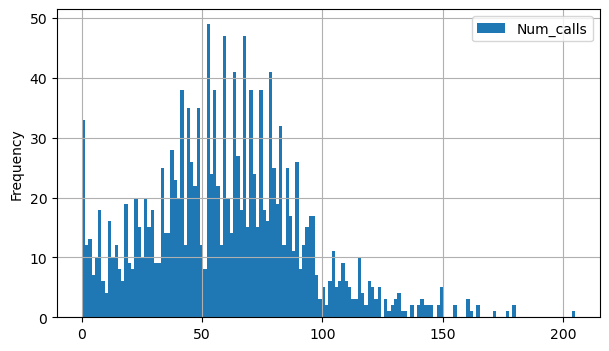

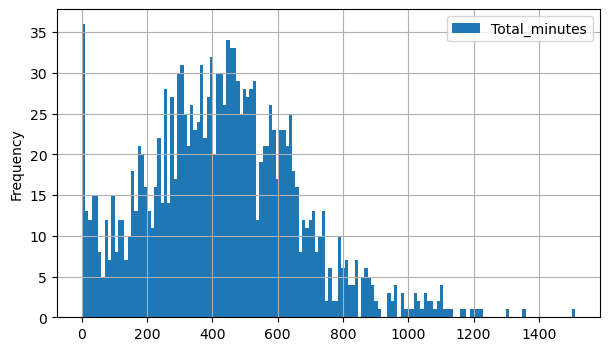

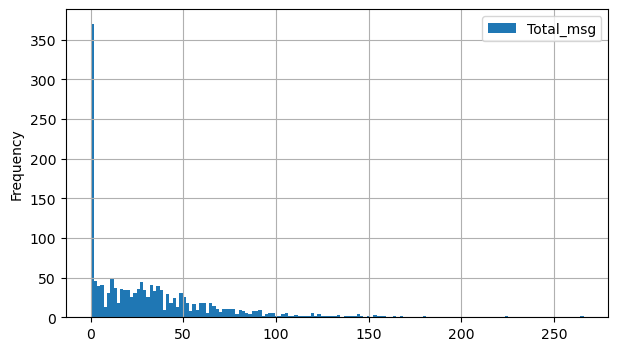

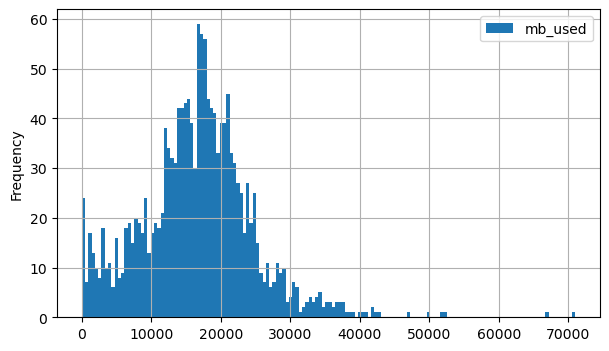

In [133]:
#Let's plot histograms for all numerical columns of table with users of Surf plan

surf_users.plot(x='user_id',y='Num_calls',kind='hist',bins=150,figsize=(7,4),grid=True)
plt.show()
surf_users.plot(x='user_id',y='Total_minutes',kind='hist',bins=150,figsize=(7,4),grid=True)
plt.show()
surf_users.plot(x='user_id',y='Total_msg',kind='hist',bins=150,figsize=(7,4),grid=True)
plt.show()
surf_users.plot(x='user_id',y='mb_used',kind='hist',bins=150,figsize=(7,4),grid=True)
plt.show()

We see that histograms of 'Num_calls', 'Total_minutes', 'mb_used' look quite similar to gaussian bell (with some outliers). 
Histograms of 'Num_calls', 'Total_minutes', 'Total messages' have peaks around zero. So from that I can conclude many people with Surf plan do not use calls and messages.

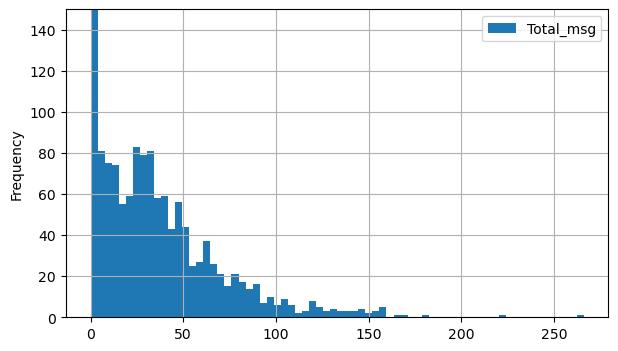

In [134]:
#Let's zoom a bit histogram for 'Total_msg'
surf_users.plot(x='user_id',y='Total_msg',kind='hist',bins = 70,figsize=(7,4),grid=True)
plt.ylim(ymin=0, ymax=150)
plt.show()

We see here that most of the people do not use the messages - we have a big peak around zero. At the same time we have a bit skewed histogram which is quite similar to right side of a bell.

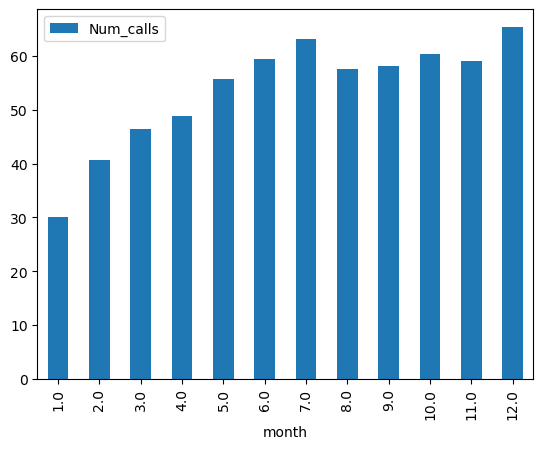

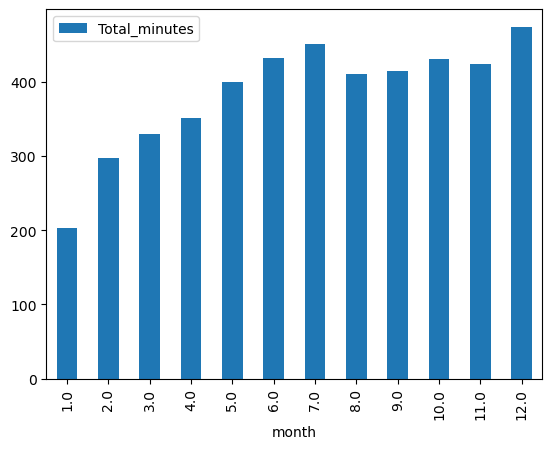

In [135]:
#Let's build the histogram from pivot_table of surf_users
surf_users.pivot_table(index='month',values='Num_calls').plot(kind='bar')
plt.show()
surf_users.pivot_table(index='month',values='Total_minutes').plot(kind='bar')
plt.show()

We see here that the average number of calls and average number of minutes of calls is increasing from the beginning of the year to the end.

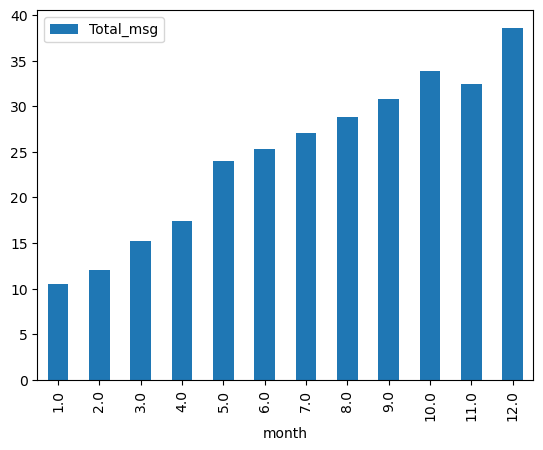

In [136]:
#Let's build the histogram from pivot_table of surf_users
surf_users.pivot_table(index='month',values='Total_msg').plot(kind='bar')
plt.show()

We see that the average number of messages sent is increasing from January to the December.

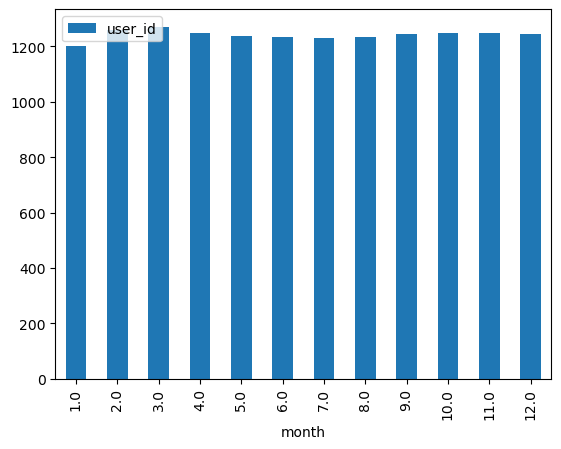

In [137]:
#Let's build the histogram showing the average number of users from month to month
surf_users.pivot_table(index='month',values='user_id').plot(kind='bar')
plt.show()

The number of Surf users from month to month is approximately the same. So we can't say about histogram above that we saw such rise of messages sent because we just have more users in December than in other months. No, number of users was approximately the same.

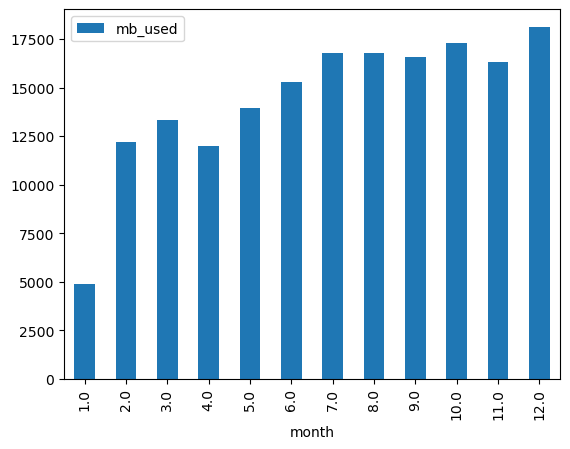

In [138]:
#histogram of average usage of megabytes by months
surf_users.pivot_table(index='month',values='mb_used').plot(kind='bar')
plt.show()

Wee also see here that the average usage of megabytes is increasing from the beginning to the end of the year.
The lowest amount of mb used was in January, and the biggest one was in December. At the same time from July till December the internet was used quite evenly.

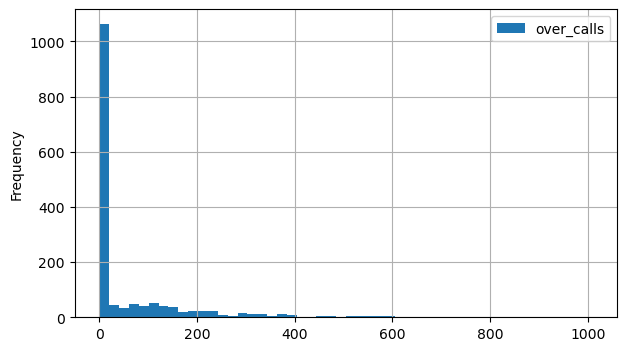

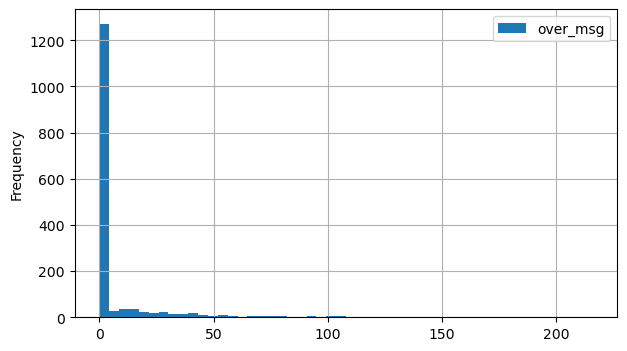

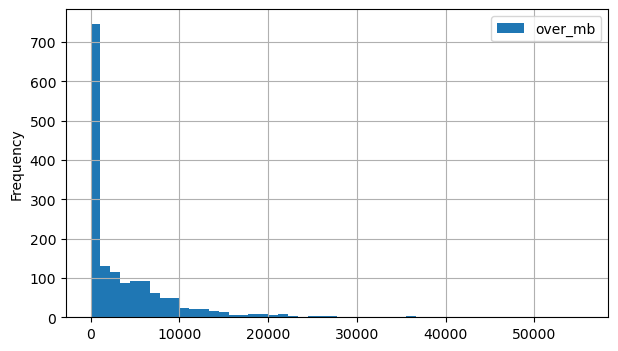

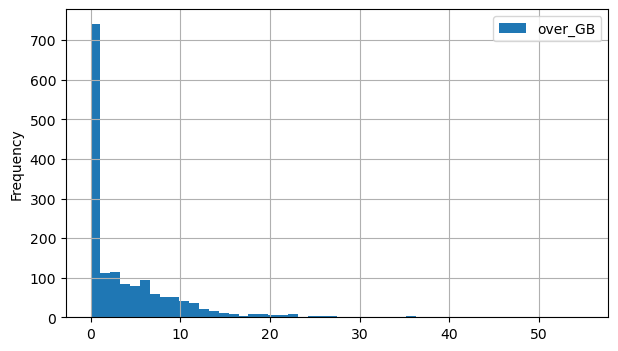

In [139]:
#plot the histogram for 'over_calls', 'over_msg', 'over_mb' and 'over_GB' columns
surf_users.plot(x='month',y='over_calls',kind='hist',bins = 50,figsize=(7,4),grid=True)
plt.show()
surf_users.plot(x='month',y='over_msg',kind='hist',bins = 50,figsize=(7,4),grid=True)
plt.show()
surf_users.plot(x='month',y='over_mb',kind='hist',bins = 50,figsize=(7,4),grid=True)
plt.show()
surf_users.plot(x='month',y='over_GB',kind='hist',bins = 50,figsize=(7,4),grid=True)
plt.show()

This is obvious that we have a lot of people who do not use calls, messages and internet traffic above the limits (big peaks around zero on plots). At the same time we have a lot of users who do that.

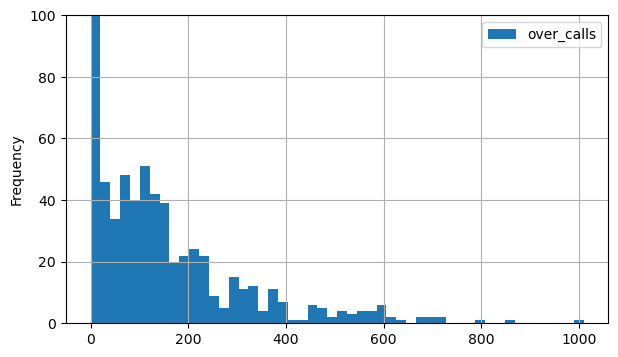

In [140]:
#let's zoom a bit plot of usage of calls above the limits
surf_users.plot(x='month',y='over_calls',kind='hist',bins = 50,figsize=(7,4),grid=True)
plt.ylim(ymin=0, ymax=100)
plt.show()

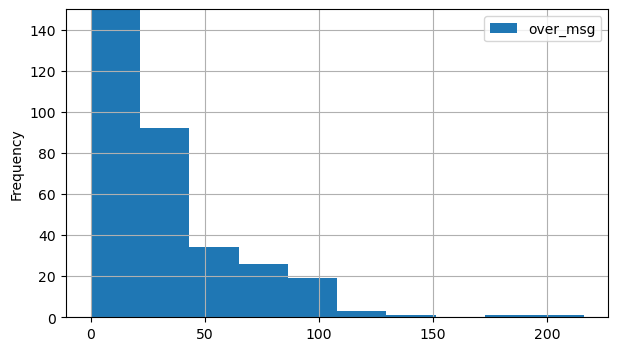

In [141]:
#let's zoom a bit histogram for 'over_msg' column
#we see that we have enough users who used messages above the limits
surf_users.plot(x='month',y='over_msg',kind='hist',figsize=(7,4),grid=True)
plt.ylim(ymin=0, ymax=150)
plt.show()

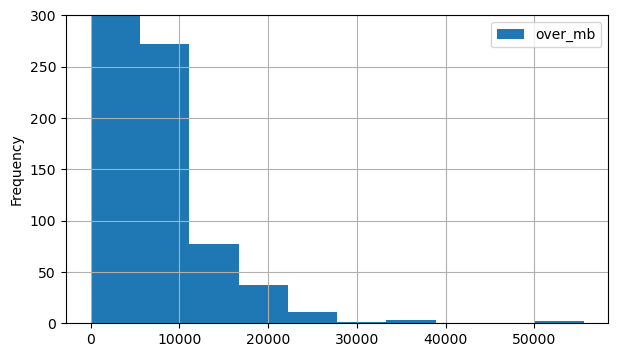

In [142]:
#let's zoom a bit histogram for 'over_mb' column
#we also see here that we have users who used megabytes above the limits
surf_users.plot(x='month',y='over_mb',kind='hist',figsize=(7,4),grid=True)
plt.ylim(ymin=0, ymax=300)
plt.show()

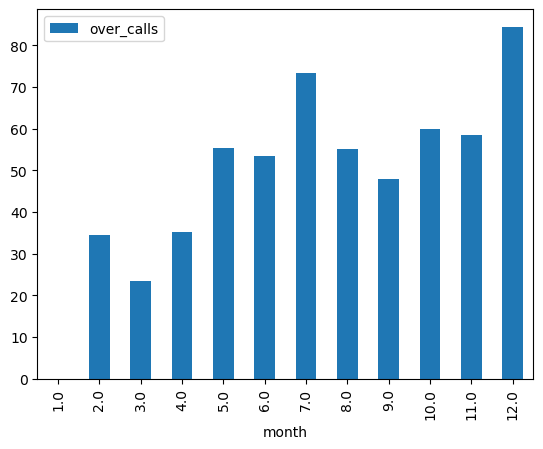

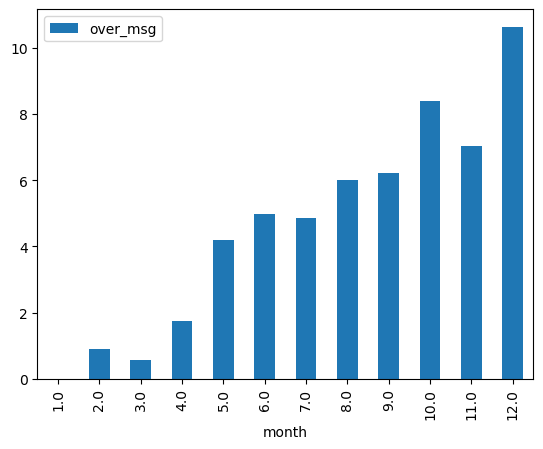

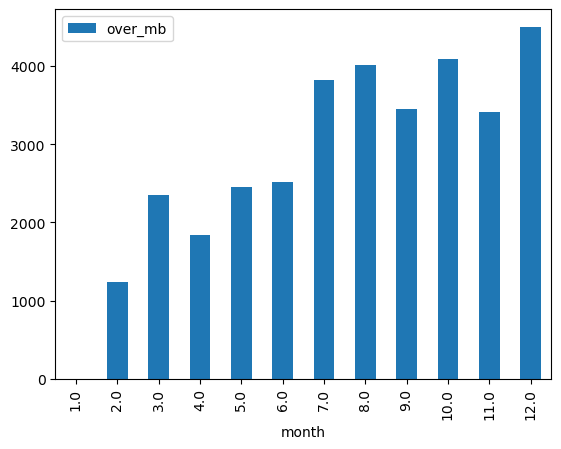

In [143]:
#Let's zoom columns with data about usage of services above the limits for more detailed insights
#for that I will build a pivot tables with average usage of services for each month

surf_users.pivot_table(index='month',values='over_calls').plot(kind='bar')
plt.show()
surf_users.pivot_table(index='month',values='over_msg').plot(kind='bar')
plt.show()
surf_users.pivot_table(index='month',values='over_mb').plot(kind='bar')
plt.show()

We see here that for Surf plan:
- The biggest number of calls used above the limit was in December. We also have peak in July.
- The number of messages used above the limit was increasing from the beginning to the end of the year. 
- The number of megabytes used above the limit was increasing towards the end of the year. 
- In July, August, October and December we have highest peaks of usage of internet traffic above the plan limits.
- We don't have data that megabytes was used above the limit in January.

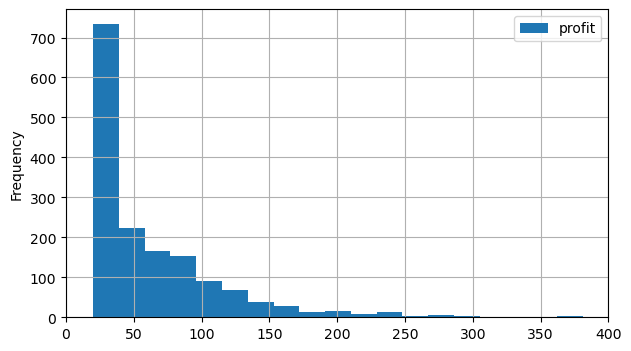

In [144]:
surf_users.plot(x='month',y='profit',kind='hist',bins=30,figsize=(7,4),grid=True)
plt.xlim(xmin=0,xmax=400)
plt.show()

Such as the monthly plan charge for Surf plan is 20$ we see the peak between 0 and 50 on a plot

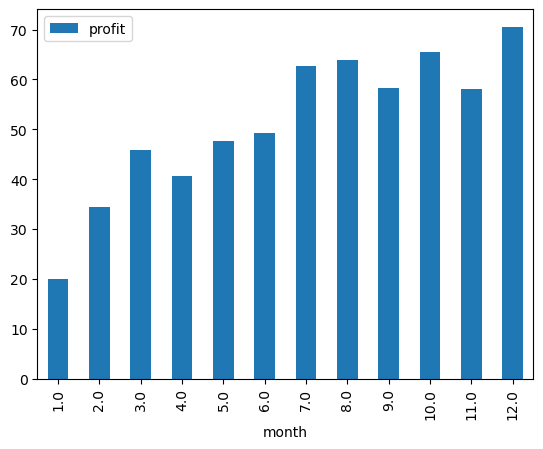

In [145]:
surf_users.pivot_table(index='month',values='profit').plot(kind='bar')
plt.show()

We see that average profit is increasing towards the end of the year. Because on previous histograms we saw that usage of calls, minutes and megabytes above the limits is increased from the beginning to the end of the year it is connected that the profit is also increasing.

Now let's plot the same histograms for users of Ultimate plan.

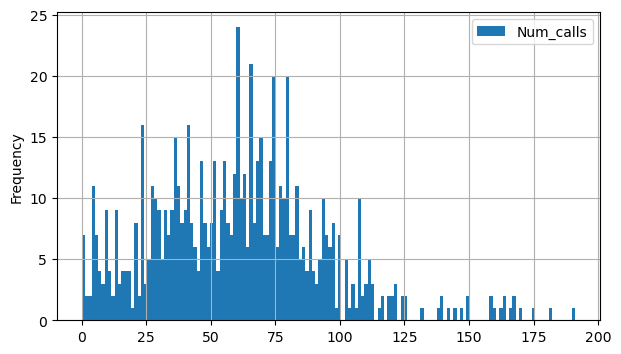

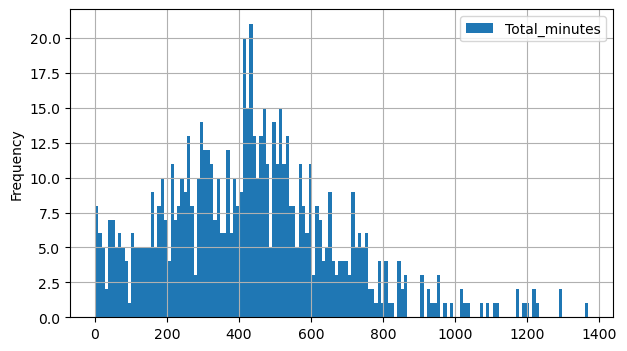

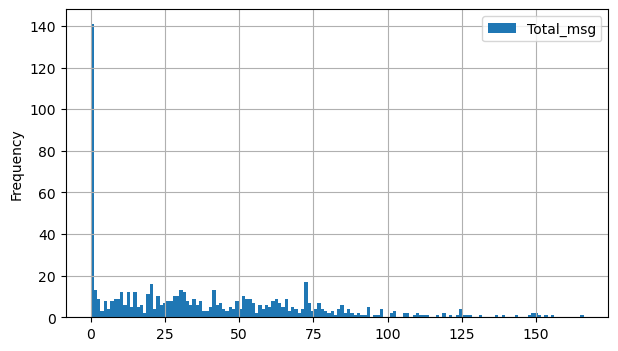

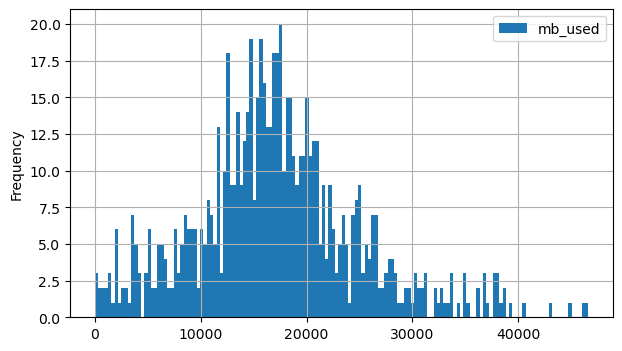

In [146]:
#Let's plot histograms for all numerical columns of table with users of Ultimate plan

ultimate_users.plot(x='month',y='Num_calls',kind='hist',bins=150,figsize=(7,4),grid=True)
plt.show()
ultimate_users.plot(x='month',y='Total_minutes',kind='hist',bins=150,figsize=(7,4),grid=True)
plt.show()
ultimate_users.plot(x='month',y='Total_msg',kind='hist',bins=150,figsize=(7,4),grid=True)
plt.show()
ultimate_users.plot(x='month',y='mb_used',kind='hist',bins=150,figsize=(7,4),grid=True)
plt.show()

We see on histograms that at least plots for 'Num_calls', 'total_minutes' and 'mb_used' look similar to the normal distribution. 
For total messages column we see a big peak around zero, so we can conclude that many people do not use messages.
The column 'Num of calls' is also looks quite similar to normal distribution but quite noisy.

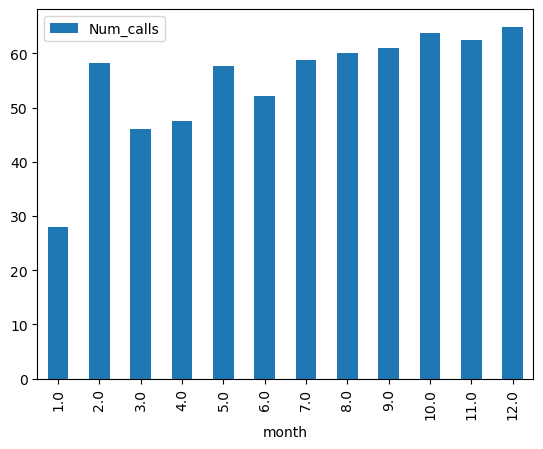

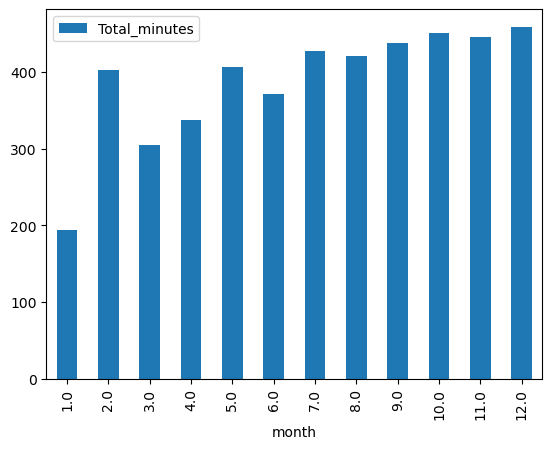

In [147]:
#Let's build the histogram from pivot_table of average usage of calls for ultimate_users
ultimate_users.pivot_table(index='month',values='Num_calls').plot(kind='bar')
plt.show()
ultimate_users.pivot_table(index='month',values='Total_minutes').plot(kind='bar')
plt.show()

We see that usage of calls by users of Ultimate plan is also increasing towards the end of the year. But we also have a strange peak in February. 

Let's check if the users distributed evenly by the months.

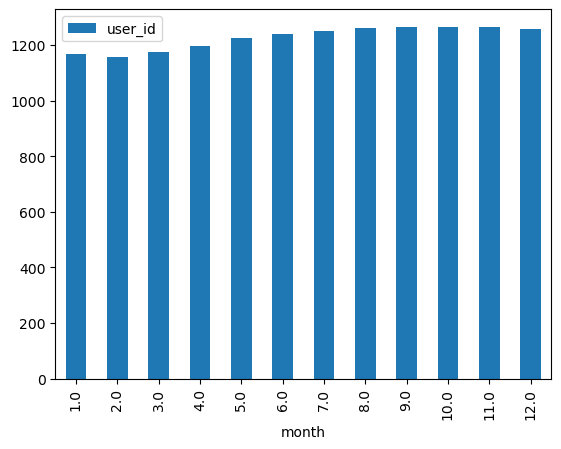

In [148]:
ultimate_users.pivot_table(index='month',values='user_id').plot(kind='bar')
plt.show()

We see that users of Ultimate plan are distributed evenly by the months.

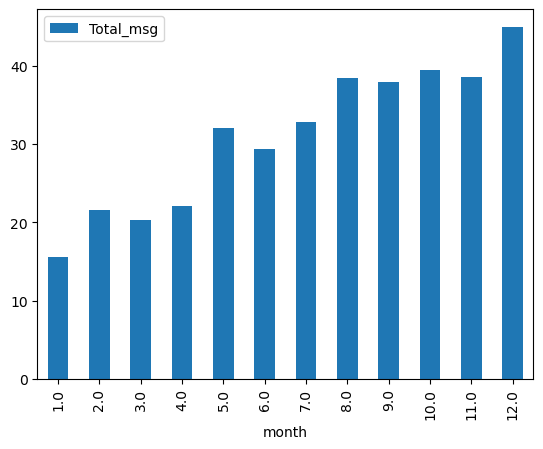

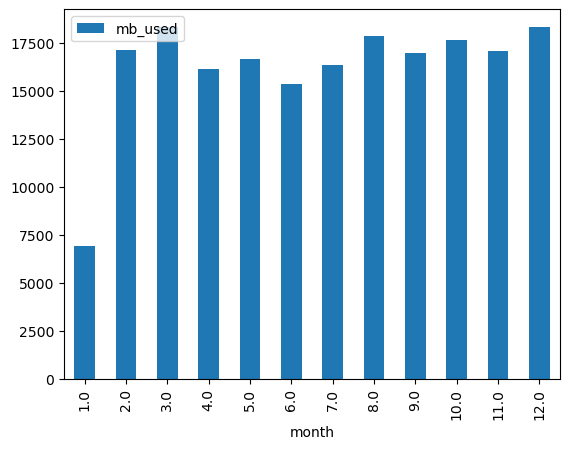

In [149]:
#Let's build the histogram from pivot_table of average usage of messages and megabytes for ultimate_users
ultimate_users.pivot_table(index='month',values='Total_msg').plot(kind='bar')
plt.show()
ultimate_users.pivot_table(index='month',values='mb_used').plot(kind='bar')
plt.show()

We see here that usage of messages is increasing as for other parameters from the beginning towards the end of the year.
At the same time usage of megabytes by users of Ultimate plan is distributed quite evenly except of the January when the usage is twice lower. 

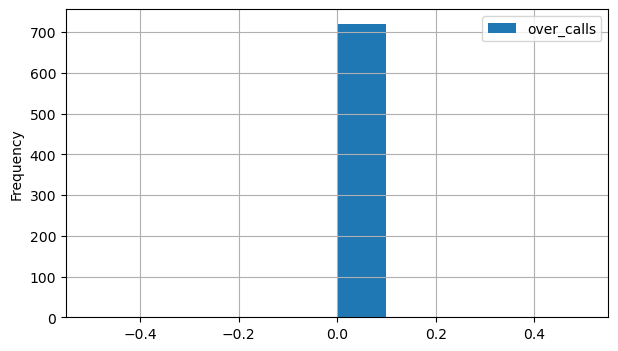

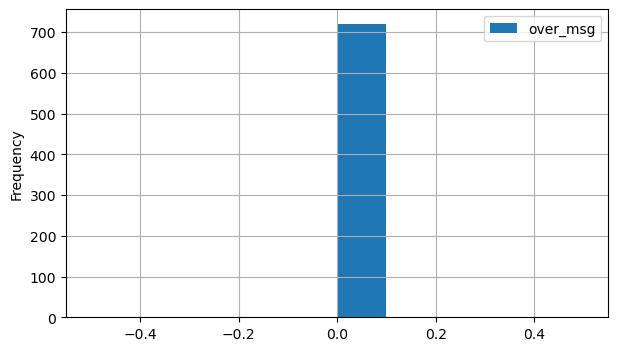

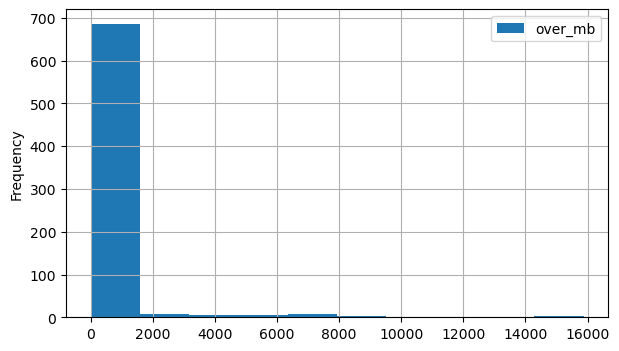

In [150]:
#let's plot histograms for columns of usage of calls, messages and megabytes above the limits
ultimate_users.plot(x='month',y='over_calls',kind='hist',figsize=(7,4),grid=True)
plt.show()
ultimate_users.plot(x='month',y='over_msg',kind='hist',figsize=(7,4),grid=True)
plt.show()
ultimate_users.plot(x='month',y='over_mb',kind='hist',figsize=(7,4),grid=True)
plt.show()

We know from before that we do not have users of Ultimate plan who went above the limits of usage calls and messages. So we see that once again on histograms.
At the same time we can't say the same for usage of megabytes above the limits. We have 41 user of Ultimate plan who went above the limits. We can see that more closely on the plot below.

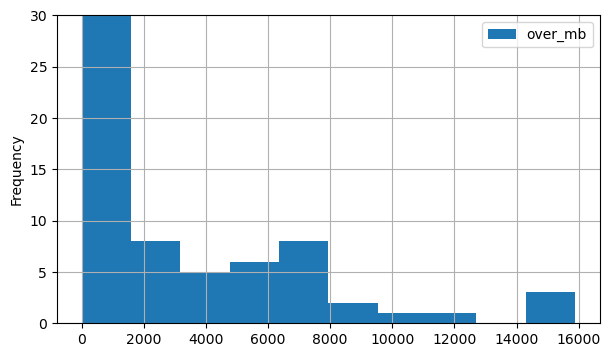

In [151]:
#users of ultimate plan who used megabytes more than plan limit is
ultimate_users.plot(x='month',y='over_mb',kind='hist',figsize=(7,4),grid=True)
plt.ylim(ymin=0, ymax=30)
plt.show()

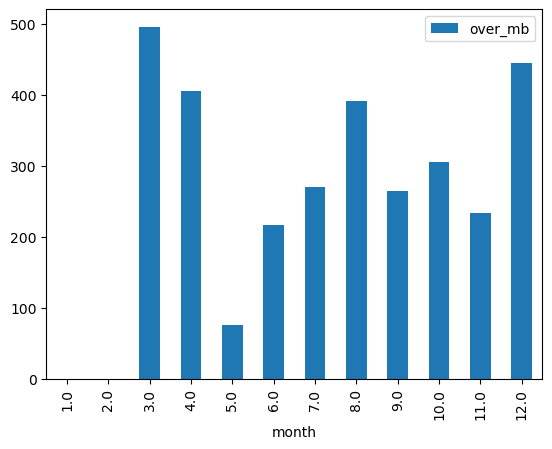

In [152]:
#let's see how over usage of megabytes is distributed by months of the year
ultimate_users.pivot_table(index='month',values='over_mb').plot(kind='bar')
plt.show()

We see that we don't have users of Ultimate plan who used megabytes above the limits in February and January. We also have big peaks in March and December. Peak in March even bigger than peak in December.

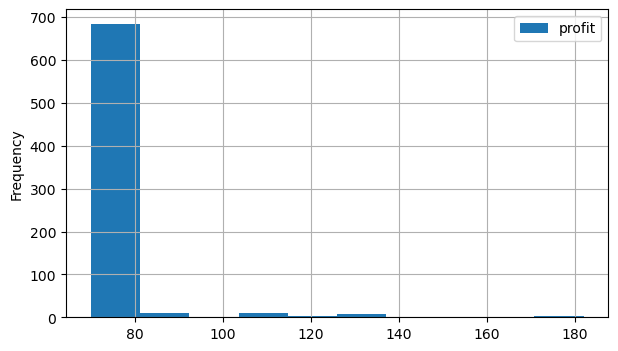

In [153]:
#Let's plot profit for ultimate plan
ultimate_users.plot(x='month',y='profit',kind='hist',figsize=(7,4),grid=True)
plt.show()

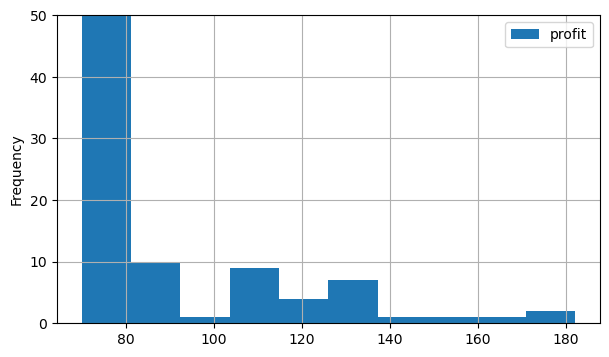

In [154]:
ultimate_users.plot(x='month',y='profit',kind='hist',figsize=(7,4),grid=True)
plt.ylim(ymin=0, ymax=50)
plt.show()

We see on histograms above big peaks between 0 and 80. The monthly plan charge for ultimate plan is 70$. So because of it we have such peak. Let's look how profit distributed by months.

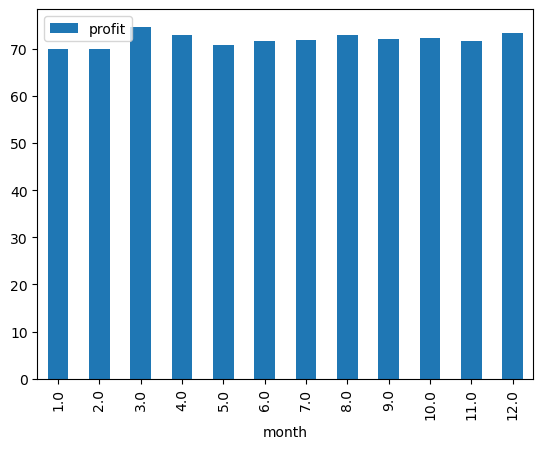

In [155]:
#let's see how profit is distributed by months of the year
ultimate_users.pivot_table(index='month',values='profit').plot(kind='bar')
plt.show()

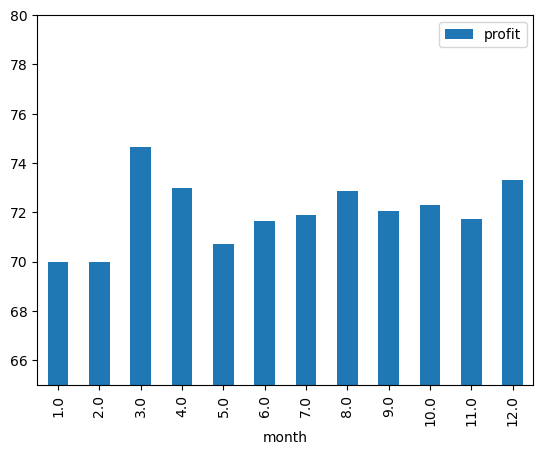

In [156]:
ultimate_users.pivot_table(index='month',values='profit').plot(kind='bar')
plt.ylim(ymin=65,ymax=80)
plt.show()

The profit from users of Ultimate plan is distributed very evenly by months. If look more closely we see the peak of profit in March when we had peak of usage of internet above the limits, so everything is interconnected. We also have peaks in March, April and December.

### Conclusion

I analyzed the data. I can make following conclusions about behavior of users of two plans:

**Some points of behavior of Surf plan users:**
* Users require in average 59 calls per month
* If count in minutes: users require in average 428 minutes for calls each month.
* If assuming that 59 calls will last 428 minutes, each call last about 7,25 minutes.
* Users require 31 messages in average per month
* Users require 16558 megabytes in average per month

**How many minutes, messages, megabytes users of Surf plan lack:**
* Users lack inside tariff plan 61 minutes of calls (or if assume that one call last 7,25 minutes - Users lack about 8 calls)
* Users lack inside tariff plan in average 7 messages per month
* Users lack inside tariff plan in average 3.86 GB per month

**Percentage of Surf users who went out of limits:**
* Percentage of Surf users who went out of minutes limits 35.98%
* Percentage of Surf users who went out of messages limits 21.61%
* Percentage of Surf users who went out of megabytes limits 57.91%

**Percentage of Surf users who did not used the services:**
* Percentage of surf users who did not used the calls 1.84%
* Percentage of surf users who did not used the messages 22.31%
* Percentage of surf users who did not used the megabytes 0.95%

**Some points of behavior of Ultimate plan users:**
* Users of Ultimate plan require in average 60 calls per month (almost the same as Surf plan users)
* If count these calls in minutes: users require in average 430 minutes for calls each month
* Average duration of call for is also about 7,1 minutes
* Users of Ultimate plan require 37 messages in average per month
* Users of Ultimate plan require 17214 megabytes in average per month

**How many minutes, messages, megabytes users of Ultimate plan lack:**
* Users of Ultimate plan do not need of additional minutes of calls or messages. They do not have lack of minutes or calls.
* In average users of Ultimate plan lack of 309 megabytes of internet traffic

**Percentage of Ultimate plan users who went out of limits:**
* We do not have users of Ultimate plan who made calls and messages more than they already have in plan.
* Percentage of Ultimate users who went out of megabytes limits 5.69% or 41 user

**Percentage of Ultimate plan users who did not used the services:**
* Percentage of Ultimate users who did not used the calls 1.11%
* Percentage of Ultimate users who did not used the messages 18.89%
* Percentage of Ultimate users who did not used the megabytes 0.14%

I calculated mean, variance and standard deviation for each numerical column for users of both plans. I also plotted histograms. From that I can conclude:

**For users of Surf plan**
- Distribution of Num_calls', 'Total_minutes', 'mb_used' on histograms looks normal, similar to gaussian bell (with some outliers).
- Histograms of 'Num_calls', 'Total_minutes', 'Total messages' have peaks around zero. So from that I can conclude many people with Surf plan do not use calls and messages.
- The average number of calls and average number of minutes of calls is increasing from the beginning of the year towards the end of the year.
- The average number of messages sent is increasing from January to the December.
- The average usage of megabytes is increasing from the beginning to the end of the year. 
- The lowest amount of mb used was in January, and the biggest one was in December. 
- From July till December the internet was used quite evenly.
- The number of Surf users from month to month is approximately the same. So the rise of calls, messages and usage of internet traffic is not caused by increase of number of users.
- The biggest number of calls used above the limit was in December. We also have peak in July.
- The number of messages used above the limit was increasing from the beginning to the end of the year.
- The number of megabytes used above the limit was increasing towards the end of the year.
- In July, August, October and December we have highest peaks of usage of internet traffic above the plan limits.
- We don't have data that megabytes was used above the limit in January.
- Such as the monthly plan charge for Surf plan is 20 dollars we see the peak between 0 and 50 on a histogram
- We see that profit is increasing towards the end of the year.

**For users of Ultimate plan**
- Histograms for 'Num_calls', 'total_minutes' and 'mb_used' look similar to the normal distribution
- For total messages column we see a big peak around zero, so we can conclude that many people do not use messages. 
- We see that usage of calls by users of Ultimate plan is also increasing towards the end of the year. But we also have a strange peak in February.
- We see that users of Ultimate plan are distributed evenly by the months.
- Usage of messages is increasing as for other parameters from the beginning towards the end of the year. 
- Usage of megabytes by users of Ultimate plan is distributed quite evenly except of the January when the usage is twice lower.
- We do not have users of Ultimate plan who went above the limits of usage calls and messages.
- We have 41 user of Ultimate plan who went above the limits in usage of internet traffic. 
- We don't have users of Ultimate plan who used megabytes above the limits in February and January. 
- We have big peaks of usage megabytes above the limit in March and December. Peak in March even bigger than peak in December.
- On the histogram for profit we see big peaks between 0 and 80. The monthly plan charge for ultimate plan is 70 dollars.So because of it we have such peak.
- The profit from users of Ultimate plan is distributed very evenly by months.
- We have the peak of profit in March when we had peak of usage of internet above the limits.

### Step 4. Test the hypotheses

- You decide what alpha value to use.
- Explain: How you formulated the null and alternative hypotheses.
- What criterion you used to test the hypotheses and why.

**The average profit from users of Ultimate and Surf calling plans differs.**

In [157]:
#Let's count average profit for Surf and Ultimate tables
print('Average profit from surf users',surf_users['profit'].mean())
print('Average profit from ultimate users',ultimate_users['profit'].mean())

Average profit from surf users 60.70640813731715
Average profit from ultimate users 72.31388888888888


In [158]:
print('Dispersion of profit from surf users',np.var(surf_users['profit']))
print('Dispersion of profit from ultimate users',np.var(ultimate_users['profit']))

Dispersion of profit from surf users 3065.8848438690225
Dispersion of profit from ultimate users 129.66814043209837


To get to know that **the average profits from users of Ultimate and Surf calling plans differs** let's test the following hypotheses. The null hypothesis, H0, is a statement of “no effect” or “no difference” or mean values are equal. The alternative hypothesis tells that the average profits or mean values are not equal: 

- **H0** - the average profits from users of Ultimate and Surf calling plans **are equal**
- **H1** - the average profits from users of Ultimate and Surf calling plans **are not equal**

Let's apply the method scipy.stats.ttest_ind(array1, array2, equal_var) to test our hypothesis. 
 
Dispersions of profits of two plans differs a lot. So because of that we should use **equal_var = False** parameter.

In [159]:
#array1, array2 - surf_users['profit'] and ultimate_users['profit']
#equal_var = False (True means we consider the variances equal, False means we don't)

alpha = .05 # critical statistical significance level
            # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        surf_users['profit'], 
        ultimate_users['profit'],
        equal_var = False)

print('statistical significance level',alpha)
print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

statistical significance level 0.05
p-value:  3.1703905481135734e-15
We reject the null hypothesis


In [160]:
#Let's do the same for the same hypothesis but with different significance level
alpha = .01 # critical statistical significance level
            # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        surf_users['profit'], 
        ultimate_users['profit'],
        equal_var = False)

print('statistical significance level',alpha)
print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

statistical significance level 0.01
p-value:  3.1703905481135734e-15
We reject the null hypothesis


We see from two test set above that we should reject the null hypothesis with 1% and 5% critical statistical significance level. 

This means **we reject the hypothesis that the average profits** from users of Ultimate and Surf calling plans **are  equal.** 

**So we confirm that average profit from users of Ultimate and Surf calling plans differs.**

Let's test the second hypothesis:

**The average profit from users in NY-NJ area is different from that of the users from other regions.**

In [161]:
#Let's add to the tables df_merged, surf_users and ultimate_users location data to complete the task

#data about location we have in megaline_users table
megaline_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


In [162]:
#Let's create a data slice with user id and cities
user_location = megaline_users[['user_id','city']]

In [163]:
#add the data of city where user lives to the df_merged table
df_merged = pd.merge(df_merged,user_location,how='left', on='user_id')
df_merged.head()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB,profit,city
0,1000,12.0,16.0,124.0,11.0,1901.47,ultimate,0.0,0.0,0.00,0,70.00,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8.0,27.0,182.0,30.0,6919.15,surf,0.0,0.0,0.00,0,20.00,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9.0,49.0,315.0,44.0,13314.82,surf,0.0,0.0,0.00,0,20.00,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10.0,65.0,393.0,53.0,22330.49,surf,0.0,3.0,6970.49,7,90.09,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11.0,64.0,426.0,36.0,18504.30,surf,0.0,0.0,3144.30,4,60.00,"Seattle-Tacoma-Bellevue, WA MSA"


In [164]:
#Let's create new categories if NY-NJ is in 'city' column - mark such column as 'NY-NJ'
#in all other cases - mark column as 'other'
searchfor = ['NY-NJ']
df_merged['location'] = df_merged['city'].apply(lambda x: 'NY-NJ' if any(i in x for i in searchfor) else 'other')

In [165]:
#let's check what we got
df_merged[df_merged['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA'].sample()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB,profit,city,location
326,1071,5.0,24.0,166.0,0.0,6403.87,surf,0.0,0.0,0.0,0,20.0,"New York-Newark-Jersey City, NY-NJ-PA MSA",NY-NJ


In [166]:
df_merged.sample()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,plan,over_calls,over_msg,over_mb,over_GB,profit,city,location
212,1050,10.0,53.0,307.0,0.0,24534.68,ultimate,0.0,0.0,0.0,0,70.0,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",other


Now in df_merged table (where we have data about users of both plans) we have location marks. If user lives in a city of NY-NJ area, he has location mark NY-NJ. Otherwise he will have a mark "other".

Let's do the same for the separate tables of Surf users and Ultimate users.

In [167]:
surf_users = pd.merge(surf_users,user_location,how='left', on='user_id')
#surf_users.info()
surf_users.head()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit,city
0,1001,8.0,27.0,182.0,30.0,6919.15,0.0,0.0,0.00,0,20.00,"Seattle-Tacoma-Bellevue, WA MSA"
1,1001,9.0,49.0,315.0,44.0,13314.82,0.0,0.0,0.00,0,20.00,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,10.0,65.0,393.0,53.0,22330.49,0.0,3.0,6970.49,7,90.09,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,11.0,64.0,426.0,36.0,18504.30,0.0,0.0,3144.30,4,60.00,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,12.0,56.0,412.0,44.0,19369.18,0.0,0.0,4009.18,4,60.00,"Seattle-Tacoma-Bellevue, WA MSA"


In [168]:
#Let's create new categories if NY-NJ is in 'city' column - mark such column as 'NY-NJ'
#in all other cases - mark column as 'other'
searchfor = ['NY-NJ']
surf_users['location'] = surf_users['city'].apply(lambda x: 'NY-NJ' if any(i in x for i in searchfor) else 'other')

In [169]:
#let's check what we got
surf_users[surf_users['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA'].sample()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit,city,location
586,1181,5.0,67.0,578.0,20.0,12394.05,78.0,0.0,0.0,0,22.34,"New York-Newark-Jersey City, NY-NJ-PA MSA",NY-NJ


In [170]:
#let's check what we got
surf_users.sample()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit,city,location
267,1090,5.0,32.0,186.0,19.0,9592.09,0.0,0.0,0.0,0,20.0,"Indianapolis-Carmel-Anderson, IN MSA",other


Let's do the same for users of Ultimate plan:
- add city column to the ultimate_users table
- create location categories for the table ('NY-NJ' and 'other')

In [171]:
ultimate_users = pd.merge(ultimate_users,user_location,how='left', on='user_id')
#ultimate_users.info()
ultimate_users.head()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit,city
0,1000,12.0,16.0,124.0,11.0,1901.47,0.0,0.0,0.00,0,70.0,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1006,11.0,2.0,10.0,15.0,2068.37,0.0,0.0,0.00,0,70.0,"San Francisco-Oakland-Berkeley, CA MSA"
2,1006,12.0,9.0,59.0,139.0,32118.82,0.0,0.0,1398.82,2,84.0,"San Francisco-Oakland-Berkeley, CA MSA"
3,1008,10.0,71.0,476.0,21.0,17106.99,0.0,0.0,0.00,0,70.0,"Orlando-Kissimmee-Sanford, FL MSA"
4,1008,11.0,63.0,446.0,37.0,23676.72,0.0,0.0,0.00,0,70.0,"Orlando-Kissimmee-Sanford, FL MSA"


In [172]:
#Let's create new categories if NY-NJ is in 'city' column - mark such column as 'NY-NJ'
#in all other cases - mark column as 'other'
searchfor = ['NY-NJ']
ultimate_users['location'] = ultimate_users['city'].apply(lambda x: 'NY-NJ' if any(i in x for i in searchfor) else 'other')

In [173]:
#check what we got
ultimate_users[ultimate_users['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA'].sample()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit,city,location
165,1113,7.0,65.0,413.0,43.0,10490.26,0.0,0.0,0.0,0,70.0,"New York-Newark-Jersey City, NY-NJ-PA MSA",NY-NJ


In [174]:
ultimate_users.sample()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit,city,location
458,1351,10.0,7.0,51.0,2.0,4823.99,0.0,0.0,0.0,0,70.0,"San Antonio-New Braunfels, TX MSA",other


So now we have in each of surf_users and ultimate_users tables as well in df_merged table a column with location marks. The user will have 'NY-NJ' mark if city of the user located in NY-NJ area, otherwise location will be marked as other.

**Let's consider the statement "The average profit from users in NY-NJ area is different from that of the users from other regions."** 
<br>  1) for table contain all users of both plans
<br>  2) separately for each plan. 

In [175]:
#Create data slices of users of both plans who live in NY-NJ area
NY_NJ_users = df_merged.query('location == "NY-NJ"')
#and for users who live in other areas
other_users = df_merged.query('location == "other"')

So we have two tables of users of both plans, one table for users who lives in NY-NJ area, and the other for users who lives in all other areas.

In [176]:
#let's count the average profit for each category of users
print('Average profit from users from NY-NJ',NY_NJ_users['profit'].mean())
print('Average profit from users from other areas',other_users['profit'].mean())

Average profit from users from NY-NJ 59.921352785145906
Average profit from users from other areas 65.22277139874734


Let's check the dispersion value for two columns of profit before the stat test.

In [177]:
print('Dispersion of profit from users from NY-NJ',np.var(NY_NJ_users['profit']))
print('Dispersion of profit from users from other areas',np.var(other_users['profit']))

Dispersion of profit from users from NY-NJ 1890.5177172681172
Dispersion of profit from users from other areas 2223.8866958162316


Dispersions differs but not so much, anyway while doing statistical test we should keep it in mind and use equal_var = False parameter for statistical test.

We should test the hypothesis:
**"The average profit from users in NY-NJ area is different from that of the users from other regions".**

Let's formulate a zero hypothesis opposite to what we should check:

- H0 - The average profit from users in NY-NJ area **is equal** to the average profit from the users from other regions
- H1 - The average profit from users in NY-NJ area **is not equal** to the average profit from the users from other regions

In [178]:
#array1, array2 - NY_NJ_users['profit'] and other_users['profit']
#equal_var = False (True means we consider the variances equal, False means we don't)

alpha = .05 # critical statistical significance level
            # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        NY_NJ_users['profit'], 
        other_users['profit'],
        equal_var = False)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

p-value:  0.0335256158853001
We reject the null hypothesis


In [179]:
#array1, array2 - NY_NJ_users['profit'] and other_users['profit']
#equal_var = False (True means we consider the variances equal, False means we don't)

alpha = .01 # critical statistical significance level
            # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        NY_NJ_users['profit'], 
        other_users['profit'],
        equal_var = False)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

p-value:  0.0335256158853001
We can't reject the null hypothesis


We see that on different levels of significanse we get different results because p-value is between 0.01 and 0.05.

For 1% significanse levels we can't reject a zero hypothesis, while for 5% significanse levels we reject the null hypothesis.

I think we get such a result because the average values of profit from users from NY-NJ and other areas quite close to each other: 
- Average profit from users from NY-NJ is 59.94 dollars
- Average profit from users from other areas 65.09 dollars

We see that difference in average profit not so high.

I tend to choose significanse levels of 1% and do not reject the null hypothesis that **The average profit from users in NY-NJ area is equal to the average profit from the users from other regions**. But it can be false result.

So for decision making I would do some more analysis, maybe repeat these test for another sample of data.

Let's check also if there any difference in average profit for the users of NY-NJ area and from the users of other regions for Surf plan and for Ultimate plan separately.

In [180]:
#Let's create data slices for users of Surf plan by their location
NY_NJ_surf_users = surf_users.query('location == "NY-NJ"')
other_surf_users = surf_users.query('location == "other"')

In [181]:
NY_NJ_surf_users.sample()

,user_id,month,Num_calls,Total_minutes,Total_msg,mb_used,over_calls,over_msg,over_mb,over_GB,profit,city,location
774,1251,8.0,83.0,614.0,20.0,34474.37,114.0,0.0,19114.37,19,213.42,"New York-Newark-Jersey City, NY-NJ-PA MSA",NY-NJ


In [182]:
#let's count the average profit for each category of users
print('Average profit from Surf users from NY-NJ',NY_NJ_surf_users['profit'].mean())
print('Average profit from Surf users from other areas',other_surf_users['profit'].mean())

Average profit from Surf users from NY-NJ 56.78958333333336
Average profit from Surf users from other areas 61.67551942902455


We see that difference of profit is not so big. It might be that in test for surf users who lived in NY-NJ and in other areas we also will get the result when p-value is between 0.01 and 0.05

In [183]:
print('Dispersion of average month profit for Surf users from NY-NJ',np.var(NY_NJ_surf_users['profit']))
print('Dispersion of average month profit for Surf users from other areas',np.var(other_surf_users['profit']))

Dispersion of average month profit for Surf users from NY-NJ 2185.486530275104
Dispersion of average month profit for Surf users from other areas 3278.9803386080566


To get to know that the average profits from users of **Surf plan** from NY-NJ area and other areas differs let's test the following hypotheses: The null hypothesis, H0, is a statement of “no effect” or “no difference” or mean values are equal. The alternative hypothesis tells that the average profits or mean values are not equal:

- H0 - the average profits from Surf users of NY-NJ area and other areas **are equal**
- H1 - the average profits from Surf users of NY-NJ area and other areas **are not equal**

Let's apply the method scipy.stats.ttest_ind(array1, array2, equal_var) to test your hypothesis.

We know that dispersions of profits differs a lot. So because of that we should use equal_var = False parameter.

In [184]:
#array1, array2 - NY_NJ_surf_users['profit'] and other_surf_users['profit'] 
#equal_var = False (True means we consider the variances equal, False means we don't)

alpha = .05 # critical statistical significance level
            # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        NY_NJ_surf_users['profit'], 
        other_surf_users['profit'],
        equal_var = False)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

p-value:  0.11593195869050535
We can't reject the null hypothesis


In [185]:
#array1, array2 - NY_NJ_surf_users_pivot['NY_NJ_profit'] and other_surf_users_pivot['other_profit'] 
#equal_var = False (True means we consider the variances equal, False means we don't)

alpha = .01 # critical statistical significance level
            # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        NY_NJ_surf_users['profit'], 
        other_surf_users['profit'],
        equal_var = False)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

p-value:  0.11593195869050535
We can't reject the null hypothesis


In both tests with 1% and 5% level of significance we can't reject the hypothesis that the average profits from Surf users of NY-NJ area and other areas are equal. So we confirm that users of Surf plan brings equal profit wherever they live.

Let's check the same for users of Ultimate plan.

In [186]:
#Let's create data slices for users of Surf plan by their location
NY_NJ_ult_users = ultimate_users.query('location == "NY-NJ"')
other_ult_users = ultimate_users.query('location == "other"')

Let's check the average profit and dispersion value for Ultimate users who lives in NY-NJ area and other areas.

In [187]:
#let's count the average profit for each category of users
print('Average profit from Surf users from NY-NJ',NY_NJ_ult_users['profit'].mean())
print('Average profit from Surf users from other areas',other_ult_users['profit'].mean())

Average profit from Surf users from NY-NJ 74.95384615384616
Average profit from Surf users from other areas 72.05190839694656


In [188]:
print('Dispersion of average month profit for Ultimate users from NY-NJ')
print(np.var(NY_NJ_ult_users['profit']))
print('Dispersion of average month profit for Ultimate users from other areas')
print(np.var(other_ult_users['profit']))

Dispersion of average month profit for Ultimate users from NY-NJ
201.6132544378701
Dispersion of average month profit for Ultimate users from other areas
121.76829788473636


To get to know that the average profits from users of Ultimate plan from NY-NJ area and other areas differs let's test the following hypotheses: 

* H0 - the average profits from Ultimate users of NY-NJ area and other areas **are equal**
* H1 - the average profits from Ultimate users of NY-NJ area and other areas **are not equal**

I will use as always scipy.stats.ttest_ind(array1, array2, equal_var)  method to test your hypothesis and also I will use equal_var = False parameter such as dispersions for users from NY-NJ area and from other areas differs.

In [189]:
#array1, array2 - NY_NJ_ult_users_pivot['NY_NJ_profit'] and other_ult_users_pivot['other_profit']
#equal_var = False (True means we consider the variances equal, False means we don't)

alpha = .05 # critical statistical significance level
            # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        NY_NJ_ult_users['profit'], 
        other_ult_users['profit'],
        equal_var = False)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 


p-value:  0.11651840138106026
We can't reject the null hypothesis


In [190]:
#array1, array2 - NY_NJ_ult_users_pivot['NY_NJ_profit'] and other_ult_users_pivot['other_profit']
#equal_var = False (True means we consider the variances equal, False means we don't)

alpha = .01 # critical statistical significance level
            # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        NY_NJ_ult_users['profit'], 
        other_ult_users['profit'],
        equal_var = False)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

p-value:  0.11651840138106026
We can't reject the null hypothesis


For users of Ultimate plan as well as was for users of Surf plan we got the following confirmation:

In both tests with 1% and 5% level of significance we can't reject the hypothesis that the average profits from Ultimate users of NY-NJ area and other areas are equal. So we confirm that users of Ultimate plan brings equal profit wherever they live.

Actually it's interesting that we had controversal result for data of users of both plans from df_merged table - on 1% significanse levels we get result that we can't reject a zero hypothesis, while for 5% significanse levels we reject the null hypothesis that The average profit from users in NY-NJ area is different from that of the users from other regions.

But when I tested this hypothesis separately for each plans in both cases I get the result that I can't reject the null hypothesis and users from NY-NJ area and from other areas bring the same average profit.

### Conclusion

I tested following statements:

- The average profit from users of Ultimate and Surf calling plans differs.
- The average profit from users in NY-NJ area is different from that of the users from other regions.

For the testing the statements I formulated the null and alternative hypothesis for each statement.
For the first statement I formulated following hypotheses:

The null hypothesis, H0, is a statement of “no effect” or “no difference” or mean values are equal. The alternative hypothesis tells that the average profits or mean values are not equal:
 
- H0 - the average profits from users of Ultimate and Surf calling plans are equal
- H1 - the average profits from users of Ultimate and Surf calling plans are not equal

For the second statement I formulated following hypotheses:

- H0 - the average profits from users of NY-NJ area and other areas are equal
- H1 - the average profits from users of NY-NJ area and other areas are not equal

Second statement I tested first for users of both plans, then separately for users of each plan.

For the testing the hypotheses I used the scipy.stats.ttest_ind(array1, array2, equal_var) method. 

I can make following conclusions from the statistical test:

- With 1% and 5% critical statistical significance level I rejected hypothesis that the average profits from users of Ultimate and Surf calling plans are equal. Means **I confirm that average profit from users of Ultimate and Surf calling plans differs.**


- While testing the second hypotheses for data contain users of both plans but living in  NY-NJ area and other areas I get controversal result:
<br>For 1% significanse levels we can't reject a zero hypothesis, while for 5% significanse levels we reject the null hypothesis.
<br>The difference of average profit is not so high - 59.94 dollars for users from NY-NJ and 65.09 dollars for users from other areas.


- I tested the same statement but on data slices for each plan separately. And in both cases I got the result that with 1% and 5% level of significance I can't reject the hypothesis that the average profits from users of NY-NJ area and other areas are equal. So **I confirm that users of Ultimate plan brings equal profit wherever they live as well as users of Surf plan**. 


- On the base of the stat test for data slices of Surf and Ultimate plans, each of them confirmed that users brings equal profit wherever they live. I would choose in the test with controversal result significanse levels of 1% and do not reject a zero hypothesis. It means for data set contain users of both plans I also confirm that users brings equal profit wherever they live.

### Step 5. Write an overall conclusion

### Overall conclusion

We have dataset with five tables with data about 500 users of Megaline telecom operator. <br>
Data do not contain any errors or duplicates.
<br>

One one column ('churn_date') in table 'megaline_users' contain missing values. It has 34 non-null objects when other columns contain 500 non-null objects. We know about this column that if the value is missing there, the calling plan was being used when this data was generated. So it's ok that we have a lot of NaNs in this column. Only 34 users stopped the service when the data was retrieved.
<br>

We have one more feature of the data - we have a lot of calls with zero duration in minutes. It is about 19,48% of data. But I think it is normal to have such data. Not always you call someone sucessfully, it's usual situation.

I calculated:
- number of calls for each user per month 
- number of minutes of calls for each user per month 
- the number of messages for each user per month 
- the volume of data for each user per month 
- profit for each user per month 

After calculating the profit I deleted 10 rows of data with users for which we don't have any data about their usage of services.
There is no way to fill the missing data and count profit for them correctly. The deleting did not affect the overall result.

**Results of users behavior analysis**

**Some points of behavior of Surf plan users:**
- Users require in average 59 calls per month or 487 minutes for calls
- If assuming that 59 calls will last 428 minutes, each call last about 7,25 minutes.
- Users require 31 messages in average per month 
- Users require 16558 megabytes in average per month

**How many minutes, messages, megabytes users of Surf plan lack:**
* 61 minutes of calls (or if assume that one call last 7,25 minutes - about 8 calls)
* 7 messages per month
* 3.86 GB per month

**Percentage of Surf users who went out of limits:**
- minutes - 35.98%
- messages - 21.61%
- megabytes - 57.91%

**Percentage of Surf users who did not used the services:**
* calls - 1.84%
* messages - 22.31%
* megabytes - 0.95%

**Some points of behavior of Ultimate plan users:**
* Users require in average 60 calls per month or 428 minutes for calls
* Average duration of call for is about 7,1 minutes
* Users require 37 messages in average per month
* Users require 17119 megabytes in average per month

**How many minutes, messages, megabytes users of Ultimate plan lack:**
* Users of Ultimate plan do not have lack of minutes or calls.
* In average users of Ultimate plan lack of 307.8 megabytes of internet traffic

**Percentage of Ultimate plan users who went out of limits:**
* We do not have users of Ultimate plan who made calls and messages more than they already have in plan.
* Percentage of Ultimate users who went out of megabytes limits 5.69% or 41 user

**Percentage of Ultimate plan users who did not used the services:**
* calls - 1.11%
* messages - 18.89%
* megabytes - 0.14%

**From analysis of histograms for users of both plan I can conclude:**

- Usage of services is increasing from the beginning of the year towards the end of the year.
- Usage of services above the limits is increasing towards the end of the year
- Because of precious fact the average profit is increasing towards the end of the year
- In January we have the lowest usage of services 
- Many people do not use calls and messages.
- Almost all users use internet
- The number of users in each month is almost the same

**Results of testing hypotheses**

With 1% and 5% critical statistical significance level **I confirmed that average profit from users of Ultimate and Surf calling plans differs**.

I get interesting controversial result for test of the statement if average profit differs depending on user living location. Test on the base of data of users of both plans from df_merged table - on 1% significanse levels I get result that we can't reject a zero hypothesis, while for 5% significanse levels we reject the null hypothesis that "The average profit from users in NY-NJ area is different from that of the users from other regions".

When I tested this hypothesis separately for each plans in both cases I get the result that I can't reject the null hypothesis and **users from NY-NJ area and from other areas bring the same average profit**.

So for compared data (contain users of both plans) I tend to choose significanse levels of 1% and do not reject a zero hypothesis. It means for dataset contains users of both plans I also confirm that users brings equal profit wherever they live.